<a href="https://www.kaggle.com/code/noahnguyen08/network-science-approach-on-customer-churn?scriptVersionId=187440880" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-data-infinite-investment-systems/account_data_info.csv
/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv
/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv


In [2]:
!pip install kmodes
!pip install networkx
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 5.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import prince                 # MCA

import datetime
import category_encoders as ce

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from kmodes.kmodes import KModes
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import roc_curve, auc

from PIL import Image

# from kneed import KneeLocator
%matplotlib inline

## Loading data

In [4]:
df = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv")
test = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv")

/tmp/ipykernel_18/3662440966.py:1: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/history.csv")
/tmp/ipykernel_18/3662440966.py:2: DtypeWarning: Columns (62,64,87) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/test.csv")


In [5]:
data_info = pd.read_csv("/kaggle/input/customer-churn-data-infinite-investment-systems/account_data_info.csv", encoding = "latin-1")

In [6]:
df_copy = df[:]        # make a copy for customer churn data
test_copy = test[:]    # make a copy for test data

In [7]:
data_info_copy = data_info[:]

## Data Processing

Description of each feature

In [8]:
data_info_copy

Columns             Description  \
0                       type_code            Account Type   
1                   is_registered                     NaN   
2                    country_code                     NaN   
3                   currency_code  Currency of the Accoun   
4                       is_active                     NaN   
..                            ...                     ...   
106                    updated_at                     NaN   
107                       is_olob                     NaN   
108  retail_last_maintenance_time                     NaN   
109  retail_last_maintenance_user                     NaN   
110            visible_in_reports                     NaN   

                                          Field Values  
0    CSH - Cash/RSP (note: Registered accounts are ...  
1                                  MRL - Margin - Long  
2                                 MRS - Margin - Short  
3                               COD - Cash on Delivery  
4                                      COM - Commodity  
..                                                 ...  
106                                                NaN  
107                                                NaN  
108                                                NaN  
109                                                NaN  
110                                                NaN  

[111 rows x 3 columns]

In [9]:
data_info_copy.head(10)

Columns                                        Description  \
0        type_code                                       Account Type   
1    is_registered                                                NaN   
2     country_code                                                NaN   
3    currency_code                             Currency of the Accoun   
4        is_active                                                NaN   
5         class_id                                                NaN   
6      credit_code  Interest rate charged for debit balance. ISM A...   
7       debit_code  Debit Interest Method. An ISM ACF Code that de...   
8  last_trade_date  Last trade date in the client's account - ISM ...   
9    contract_type  Represents the shareholder information SHLDR 5...   

                                        Field Values  
0  CSH - Cash/RSP (note: Registered accounts are ...  
1                                MRL - Margin - Long  
2                               MRS - Margin - Short  
3                             COD - Cash on Delivery  
4                                    COM - Commodity  
5                                     PSP - Prospect  
6                                                NaN  
7  0  None\n 1  Normal\n [2-9] or [A-Z] (except I...  
8                                                NaN  
9  07 -if OBO: Y and Mail S \n 09 -if NOBO: Y and...

### Dealing with missing values

There are missing data in the description of some features. We'd proceed imputing these missing values with an empty string.

In [10]:
data_info_copy['Description'] = data_info_copy['Description'].fillna(' ')   # imputing missing data with empty string
data_info_copy['Field Values'] = data_info_copy['Field Values'].fillna(' ')

In [11]:
data_info_copy['Columns'][1]

'is_registered'

In [12]:
data_info_copy.head(5)

Columns             Description  \
0      type_code            Account Type   
1  is_registered                           
2   country_code                           
3  currency_code  Currency of the Accoun   
4      is_active                           

                                        Field Values  
0  CSH - Cash/RSP (note: Registered accounts are ...  
1                                MRL - Margin - Long  
2                               MRS - Margin - Short  
3                             COD - Cash on Delivery  
4                                    COM - Commodity

In [13]:
pd.set_option('display.max_columns', None)    # show all columns

In [14]:
df_copy.columns[0]

'id'

We observe that the number of columns in the data description and the customer data is not the same. We'd check what are the columns that don't exist in the customer data.

In [15]:
data_info_lst = []
customer_data_lst = []
for val in range(len(data_info_copy['Columns'])):
  data_info_lst.append(data_info_copy['Columns'][val])

for col in range(len(df_copy.columns)):
  customer_data_lst.append(df_copy.columns[col])

In [16]:
print(data_info_lst)

['type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'class_id', 'credit_code', 'debit_code', 'last_trade_date', 'contract_type', 'inception_date', 'inception_date', 'net_of_fees', 'cashflows_custody_fee', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'closing_date', 'closing_date', 'closure_reason', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'dividend_confirm_code', 'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spou

In [17]:
print(customer_data_lst)

['id', 'type_code', 'is_registered', 'country_code', 'currency_code', 'is_active', 'class_id', 'debit_code', 'last_trade_date', 'contract_type', 'inception_date', 'net_of_fees', 'cashflows_custody_fee', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'retail_plan', 'is_spousal', 'is_arp_locked', 'arp_pension_origin', 'language_code', 'dividend_confirm_code', 'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'is_midwest_clearing_account', 'rep_commission_rate', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer', 'spousal_age_flag', 'terminal_code', 'has_multiple_name', 'dec

In [18]:
info_DNE = []
for i in range(len(data_info_lst)):
  if data_info_lst[i] not in customer_data_lst:
    info_DNE.append(data_info_lst[i])

In [19]:
info_DNE

['credit_code', 'closing_date', 'closing_date', 'closure_reason']

These are the columns that didn't appear on the customer data.

In [20]:
df_copy['country_code'].isnull().value_counts()

country_code
True     669050
False      4289
Name: count, dtype: int64

In [21]:
df_copy['currency_code'].isnull().value_counts()

currency_code
False    673339
Name: count, dtype: int64

`country_code` and `currency_code` have the same purpose, let's say your currency code is CAD, it's likely that you are from Canada, thus the `country_code` may not contribute any useful information. Thus we'd drop this column.

In [22]:
df_copy = df_copy.drop('country_code', axis=1)

In [23]:
df_copy['cashflows_custody_fee'].isnull().value_counts()

cashflows_custody_fee
True    673339
Name: count, dtype: int64

As all the records in `cashflows_custody_fee` are missing, we'd just drop this column as well.

In [24]:
df_copy = df_copy.drop('cashflows_custody_fee', axis=1)

In [25]:
df_copy['esir_number'].isnull().value_counts()

esir_number
True     673327
False        12
Name: count, dtype: int64

In [26]:
df_copy = df_copy.drop('esir_number', axis=1)

In [27]:
def missing_data_per_col(data):
  '''
    Show the number of missing values
    in each column

    input: data
  '''
  null_count = []
  missing_data = {}
  for col in data.columns:
    missing_data[col] = [data[col].isna().sum()]
  missing_df = pd.DataFrame(missing_data)
  missing_df = missing_df.rename(columns = {0: "Number of missing values"})
  return missing_df


In [28]:
missing_data_df = missing_data_per_col(df_copy)

In [29]:
missing_data_df

id  type_code  is_registered  currency_code  is_active  class_id  \
0   0        237              0              0          0      3198   

   debit_code  last_trade_date  contract_type  inception_date  net_of_fees  \
0        3198           307875          95823            3198            0   

   fee_paid_separately  custody_fee_withdrawal  is_fee_exempt  branch  \
0                    0                       0              0    3198   

   include_client_consolidation  use_client_address  credit_limit_type  \
0                             0                   0               3198   

   retail_plan  is_spousal  is_arp_locked  arp_pension_origin  language_code  \
0       316985      313694         313694              632725           3198   

   dividend_confirm_code  sss_location  options_trading_type  sss_type  \
0                   3198        668258                  3198    668258   

   sss_agent  is_midwest_clearing_account  rep_commission_rate  \
0     668273                         3198                 3198   

   rep_commission_override  interest_dividend_conversion_type  \
0                     3198                               3198   

   guarantee_gtor_type  use_hand_delivery  use_mail  \
0                 3198                  0         0   

   share_name_address_to_issuer  shareholder_instructions_received  \
0                             0                                  0   

   rrsp_limit_reached  is_portfolio_account  has_no_min_commission  \
0                   0                     0                      0   

   is_tms_eligible  is_agent_bbs_participant  is_parameters_account  \
0                0                         0                      0   

   is_spousal_transfer  spousal_age_flag  terminal_code  has_multiple_name  \
0                    0                 0          77413                  0   

   deceased_fair_market_value  target_grantor_grantee_flag  \
0                        3198                       504876   

   discretionary_trading_authorized  iso_funds_code  shareholder_language  \
0                             76123            3198                623554   

   dup_trip_quad_code  special_tag  conjunction   title  function_code  \
0                3210       626904       657891  186266         669102   

   tms_settlement_location  portfolio_cost_method  \
0                   665590                   3198   

   portfolio_name_address_option  portfolio_report_option  \
0                           3198                     3198   

   portfolio_summary_option  receive_general_mailings  loan_limit_override  \
0                      3198                         0               642194   

   interactive_portfolio_code  non_plan_book_value_flag  has_discrete_auth  \
0                        3198                    368978              96045   

   last_update_date  is_non_objecting_beneficial_owner  \
0            111327                                  0   

   is_objecting_to_disclose_info  mailing_consent  consent_to_pay_for_mail  \
0                              0             3198                        0   

   consent_to_email_delivery  has_received_instruction  risk_tolerance  \
0                          0                         0          145530   

   investment_objective  is_broker_account  is_inventory_account  \
0                145453                  0                     0   

   is_gl_account  is_control_account  is_extract_eligible  \
0              0                   0                    0   

   last_maintenance_time  last_maintenance_user  is_pledged  special_fee_code  \
0                   3538                   3198      316985            673271   

   non_calendar_year_end  plan_effective_date  plan_end_date  is_resp  \
0                 316985               316985         517718   316985   

   number_of_beneficiaries  rrif_original_date  \
0                   316985              316985   

   use_original_date_for_payment_calc  is_family_resp  is_hrdc_resp  \
0 

In [30]:
len(missing_data_df.columns)

103

### Analyzing the contribution of each feature

#### Categorical features that have too many categories -> K-modes clustering

In [31]:
print("Number of categories in class_id: ", len(df_copy['class_id'].unique()))
print("Number of categories in terminal_code: ", len(df_copy['terminal_code'].unique()))
print("Number of categories in sss_agent: ", len(df_copy['sss_agent'].unique()))
print("Number of categories in deceased_fair_market_value: ", len(df_copy['deceased_fair_market_value'].unique()))
print("Number of categories in risk_tolerance: ", len(df_copy['risk_tolerance'].unique()))
print("Number of categories in investment_objective: ", len(df_copy['investment_objective'].unique()))
print("Number of categories in last_maintenance_user: ", len(df_copy['last_maintenance_user'].unique()))
print("Number of categories in special_fee_code: ", len(df_copy['special_fee_code'].unique()))
print("Number of categories in retail_last_maintenance_user: ", len(df_copy['retail_last_maintenance_user'].unique()))
print(len(df_copy['retail_last_maintenance_user'].unique()))

Number of categories in class_id:  66
Number of categories in terminal_code:  1439
Number of categories in sss_agent:  3816
Number of categories in deceased_fair_market_value:  2126
Number of categories in risk_tolerance:  848
Number of categories in investment_objective:  1472
Number of categories in last_maintenance_user:  445
Number of categories in special_fee_code:  36
Number of categories in retail_last_maintenance_user:  433
433


Drop `rep_commission_rate`, `dup_trip_quad_code`, `portfolio_cost_method`, `portfolio_name_address_option` columns as they only have one single value.

In [32]:
# df_copy = df_copy.drop('rep_commission_rate', axis=1)
# df_copy = df_copy.drop('dup_trip_quad_code', axis=1)
# df_copy = df_copy.drop('portfolio_cost_method', axis=1)
# df_copy = df_copy.drop('portfolio_name_address_option', axis=1)
# df_copy = df_copy.drop('portfolio_summary_option', axis=1)
# df_copy = df_copy.drop('interactive_portfolio_code', axis=1)
# df_copy = df_copy.drop('non_plan_book_value_flag', axis=1)

In [33]:
df_copy

id       type_code is_registered currency_code is_active  \
0        893724      CASH SWEEP             f           CAD         t   
1       1268094            RRIF             t           CAD         t   
2        606613    SPOUSAL RRSP             t           CAD         t   
3        741930            CASH             f           CAD         t   
4       1137922            CASH             f           CAD         t   
...         ...             ...           ...           ...       ...   
673334  6827067  LIRA/LRSP/RLSP             t           CAD         t   
673335   590659        REG RRSP             t           CAD         f   
673336  1247774            CASH             f           CAD         t   
673337  1155640            RRIF             t           CAD         t   
673338  1148378      CASH SWEEP             f           CAD         t   

        class_id debit_code last_trade_date  contract_type inception_date  \
0            3.0          0             NaN            NaN     2017-08-18   
1            5.0          C      2022-07-04           18.0     2018-11-08   
2            5.0          A      2018-07-05           16.0     2009-04-08   
3            3.0          T             NaN           12.0     2021-01-04   
4            3.0          T             NaN           17.0     2017-07-21   
...          ...        ...             ...            ...            ...   
673334       5.0          C             NaN           18.0     2023-06-27   
673335       5.0          A      2017-06-28           18.0     2006-11-23   
673336       3.0          T      2021-09-24           16.0     2019-08-30   
673337       5.0          C             NaN           17.0     2017-07-21   
673338       3.0          A             NaN            NaN     2017-08-18   

       net_of_fees fee_paid_separately custody_fee_withdrawal is_fee_exempt  \
0                f                   f                      f             f   
1                f                   f                      f             f   
2                f                   f                      f             f   
3                f                   f                      f             f   
4                f                   f                      f             f   
...            ...                 ...                    ...           ...   
673334           f                   f                      f             f   
673335           f                   f                      f             f   
673336           f                   f                      f             f   
673337           f                   f                      f             f   
673338           f                   f                      f             f   

       branch include_client_consolidation use_client_address  \
0        IAVM                            t                  f   
1        IAVM                            t                  t   
2        IAVM                            f                  f   
3        IAVM                            t                  t   
4        IAVM                            t                  f   
...       ...                          ...                ...   
673334  HOLIS                            t                  t   
673335   IAVM                            t                  f   
673336   IAVM                            t                  t   
673337   IAVM                            t                  t   
673338   IAVM                            t                  f   

        credit_limit_type retail_plan is_spousal is_arp_locked  \
0                     0.0         NaN        NaN           NaN   
1                     0.0          RI          f             f   
2                     0.0          RS          t             f   
3                     0.0         NaN        NaN           NaN   
4                     0.0         NaN        NaN           NaN   
...                   ...         ...        ...           ...   
673334             

In [34]:
df_copy_time_based_cols = df_copy[['inception_date', 'last_update_date', 'last_maintenance_time', 'rrif_original_date', 'plan_effective_date', 'plan_end_date', 'last_trade_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time']]
# for time-based columns, create dummy variables -> year, month, day and convert them to int dtype


df_copy_bool_based_cols = df_copy[['is_registered', 'is_active', 'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'include_client_consolidation', 'use_client_address',
                                   'is_spousal', 'is_arp_locked', 'is_midwest_clearing_account', 'use_hand_delivery', 'use_mail', 'share_name_address_to_issuer', 'shareholder_instructions_received',
                                   'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer',
                                   'spousal_age_flag', 'has_multiple_name', 'discretionary_trading_authorized', 'receive_general_mailings', 'has_discrete_auth', 'is_non_objecting_beneficial_owner',
                                   'is_objecting_to_disclose_info', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_broker_account', 'is_inventory_account',
                                   'is_gl_account', 'is_control_account', 'is_extract_eligible', 'is_pledged', 'is_resp', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp',
                                   'is_plan_grandfathered', 'is_olob', 'visible_in_reports']]

# for bool-based columns, convert to binary (0 and 1)

df_copy_categorical_based_cols = df_copy[['type_code', 'currency_code', 'class_id', 'debit_code', 'contract_type', 'branch', 'credit_limit_type', 'retail_plan', 'arp_pension_origin', 'language_code', 'dividend_confirm_code',
                                          'sss_location', 'options_trading_type', 'sss_type', 'sss_agent', 'rep_commission_override', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'terminal_code',
                                          'deceased_fair_market_value', 'target_grantor_grantee_flag', 'iso_funds_code', 'shareholder_language', 'special_tag', 'conjunction', 'title', 'function_code', 'tms_settlement_location',
                                          'portfolio_report_option', 'loan_limit_override', 'mailing_consent', 'risk_tolerance', 'investment_objective', 'last_maintenance_user', 'special_fee_code', 'non_calendar_year_end',
                                          'number_of_beneficiaries', 'resp_specimen_plan', 'retail_last_maintenance_user']]

# for categorical-based columns, perform clustering (for features that contain a lot of categories)

# the number of clusters will be decided by elbow method (or domain knowledge)

Check if there is any missing columns after assigning columns into variables

In [35]:
count_missing_col = 0
for i in range(len(df_copy_time_based_cols.columns)):
  if df_copy_time_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1

for i in range(len(df_copy_bool_based_cols.columns)):
  if df_copy_bool_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1

for i in range(len(df_copy_categorical_based_cols.columns)):
  if df_copy_categorical_based_cols.columns[i] not in df_copy.columns:
    count_missing_col += 1
print(count_missing_col)

0


#### Check the null values in each feature

In [36]:
nan_count = df_copy.isna().sum()

In [37]:
nan_count.sort_values(axis=0).value_counts().sort_index()

0         39
237        1
3198      22
3210       1
3538       1
76123      1
77413      1
95823      1
96045      1
111327     1
145453     1
145530     1
186266     1
307875     1
313694     2
316985    12
317118     1
368978     1
504876     1
517718     1
623554     1
626904     1
632725     1
642194     1
650618     1
657891     1
665590     1
668258     2
668273     1
669102     1
673271     1
Name: count, dtype: int64

We observe that there are 39 columns that contain no missing values. We will perform clustering on those columns

In [38]:
no_nan_cols = df_copy[list(nan_count[nan_count == 0].index)]

We have to drop the target variable (label: churn or no churn)

In [39]:
no_nan_cols = no_nan_cols.drop('label', axis=1)

In [40]:
no_nan_cols = no_nan_cols.drop('id', axis=1)

In [41]:
no_nan_cols

is_registered currency_code is_active net_of_fees fee_paid_separately  \
0                  f           CAD         t           f                   f   
1                  t           CAD         t           f                   f   
2                  t           CAD         t           f                   f   
3                  f           CAD         t           f                   f   
4                  f           CAD         t           f                   f   
...              ...           ...       ...         ...                 ...   
673334             t           CAD         t           f                   f   
673335             t           CAD         f           f                   f   
673336             f           CAD         t           f                   f   
673337             t           CAD         t           f                   f   
673338             f           CAD         t           f                   f   

       custody_fee_withdrawal is_fee_exempt include_client_consolidation  \
0                           f             f                            t   
1                           f             f                            t   
2                           f             f                            f   
3                           f             f                            t   
4                           f             f                            t   
...                       ...           ...                          ...   
673334                      f             f                            t   
673335                      f             f                            t   
673336                      f             f                            t   
673337                      f             f                            t   
673338                      f             f                            t   

       use_client_address use_hand_delivery use_mail  \
0                       f                 f        f   
1                       t                 f        f   
2                       f                 f        f   
3                       t                 f        f   
4                       f                 f        f   
...                   ...               ...      ...   
673334                  t                 f        f   
673335                  f                 f        f   
673336                  t                 f        f   
673337                  t                 f        f   
673338                  f                 f        f   

       share_name_address_to_issuer shareholder_instructions_received  \
0                                 t                                 f   
1                                 t                                 f   
2                                 t                                 f   
3                                 t                                 f   
4                                 t                                 f   
...                             ...                               ...   
673334                            t                                 f   
673335                            t                                 f   
673336                            t                                 f   
673337                            t                                 f   
673338                            t                                 f   

       rrsp_limit_reached is_portfolio_account has_no_min_commission  \
0                       f                    f                     f   
1                       f                    f                     f   
2                       f                    f                     f   
3                       f                    f                     f   
4                       f                    f                     f   
...                   ...                  ...                   ...   
673334                  f                    f                     f   
673335 

In [42]:
no_nan_cols_no_time_series = no_nan_cols.drop(['inserted_at', 'updated_at'], axis=1)

In [43]:
no_nan_cols_no_time_series_dummies = pd.get_dummies(no_nan_cols_no_time_series)   # exclude time-series features

In [44]:
no_nan_cols_no_time_series_dummies

is_registered_f  is_registered_t  currency_code_CAD  \
0                  True            False               True   
1                 False             True               True   
2                 False             True               True   
3                  True            False               True   
4                  True            False               True   
...                 ...              ...                ...   
673334            False             True               True   
673335            False             True               True   
673336             True            False               True   
673337            False             True               True   
673338             True            False               True   

        currency_code_USD  is_active_f  is_active_t  net_of_fees_f  \
0                   False        False         True           True   
1                   False        False         True           True   
2                   False        False         True           True   
3                   False        False         True           True   
4                   False        False         True           True   
...                   ...          ...          ...            ...   
673334              False        False         True           True   
673335              False         True        False           True   
673336              False        False         True           True   
673337              False        False         True           True   
673338              False        False         True           True   

        fee_paid_separately_f  custody_fee_withdrawal_f  is_fee_exempt_f  \
0                        True                      True             True   
1                        True                      True             True   
2                        True                      True             True   
3                        True                      True             True   
4                        True                      True             True   
...                       ...                       ...              ...   
673334                   True                      True             True   
673335                   True                      True             True   
673336                   True                      True             True   
673337                   True                      True             True   
673338                   True                      True             True   

        include_client_consolidation_f  include_client_consolidation_t  \
0                                False                            True   
1                                False                            True   
2                                 True                           False   
3                                False                            True   
4                                False                            True   
...                                ...                             ...   
673334                           False                            True   
673335                           False                            True   
673336                           False                            True   
673337                           False                            True   
673338                           False                            True   

        use_client_address_f  use_client_address_t  use_hand_delivery_f  \
0                       True                 False                 True   
1                      False                  True                 True   
2                       True                 False                 True   
3                      False                  True                 True   
4                       True                 False                 True   
...                      ...                   ...                  ...   
673334                 False                  True                 True   
673335  

#### Feature analysis

If some of features contain duplicate information (they convey the same information to our dataset), then it's best to visualize which one they are (how they variate), and decide to drop such features (feature selection).

<Axes: >

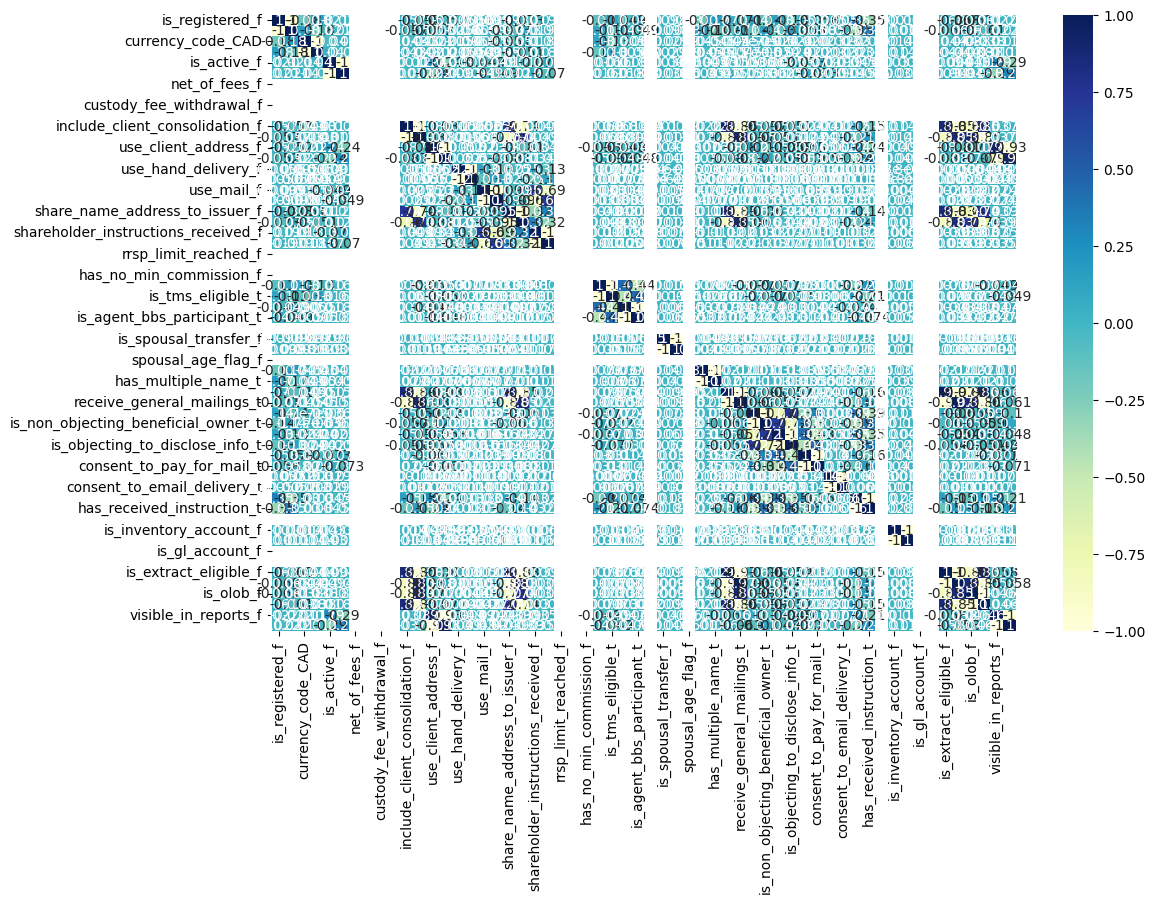

In [45]:
# correlation between features
corr_matrix = no_nan_cols_no_time_series_dummies.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot = True, cmap = 'YlGnBu')

The above is the Corr[X, Y] where X and Y represent the pair of any 2 features that we examine by correlation heatmap

In [46]:
corr_matrix

is_registered_f  is_registered_t  \
is_registered_f                             1.000000        -1.000000   
is_registered_t                            -1.000000         1.000000   
currency_code_CAD                          -0.175671         0.175671   
currency_code_USD                           0.175671        -0.175671   
is_active_f                                 0.020934        -0.020934   
is_active_t                                -0.020934         0.020934   
net_of_fees_f                                    NaN              NaN   
fee_paid_separately_f                            NaN              NaN   
custody_fee_withdrawal_f                         NaN              NaN   
is_fee_exempt_f                                  NaN              NaN   
include_client_consolidation_f              0.057361        -0.057361   
include_client_consolidation_t             -0.057361         0.057361   
use_client_address_f                        0.052288        -0.052288   
use_client_address_t                       -0.052288         0.052288   
use_hand_delivery_f                        -0.005604         0.005604   
use_hand_delivery_t                         0.005604        -0.005604   
use_mail_f                                 -0.009895         0.009895   
use_mail_t                                  0.009895        -0.009895   
share_name_address_to_issuer_f              0.073314        -0.073314   
share_name_address_to_issuer_t             -0.073314         0.073314   
shareholder_instructions_received_f        -0.019431         0.019431   
shareholder_instructions_received_t         0.019431        -0.019431   
rrsp_limit_reached_f                             NaN              NaN   
is_portfolio_account_f                           NaN              NaN   
has_no_min_commission_f                          NaN              NaN   
is_tms_eligible_f                          -0.110455         0.110455   
is_tms_eligible_t                           0.110455        -0.110455   
is_agent_bbs_participant_f                 -0.049186         0.049186   
is_agent_bbs_participant_t                  0.049186        -0.049186   
is_parameters_account_f                          NaN              NaN   
is_spousal_transfer_f                       0.009751        -0.009751   
is_spousal_transfer_t                      -0.009751         0.009751   
spousal_age_flag_f                               NaN              NaN   
has_multiple_name_f                        -0.171286         0.171286   
has_multiple_name_t                         0.171286        -0.171286   
receive_general_mailings_f                  0.070960        -0.070960   
receive_general_mailings_t                 -0.070960         0.070960   
is_non_objecting_beneficial_owner_f         0.135839        -0.135839   
is_non_objecting_beneficial_owner_t        -0.135839         0.135839   
is_objecting_to_disclose_info_f             0.125398        -0.125398   
is_objecting_to_disclose_info_t            -0.125398         0.125398   
consent_to_pay_for_mail_f                   0.058130        -0.058130   
consent_to_pay_for_mail_t                  -0.058130         0.058130   
consent_to_email_delivery_f                -0.005246         0.005246   
consent_to_email_delivery_t                 0.005246        -0.005246   
has_received_instruction_f                  0.348284        -0.348284   
has_received_instruction_t                 -0.348284         0.348284   
is_broker_account_f                              NaN              NaN   
is_inventory_account_f                      0.001029        -0.001029   
is_inventory_account_t                     -0.001029         0.001029   
is_gl_account_f                                  NaN              NaN   
is_control_account_f                             NaN              NaN   
is_extract_eligible_f                       0.068359        -0.068359   
is_extract_eligible_t                      -0.068359         0.068359   
is_olob_f             

High correlation presented: As the correlation heatmap shows, there are a few features that share a high correlation level to another, suggesting that they have a linear relationship with each other
* Linear relationship means that one feature is the linear transformation of the other, causing multicollinearity (potentially duplicate) information. Thus we would consider drop one of them.
* We will set a threshold of 0.5 for the correlation level; any pair of features whose level of correlation exceeds the threshold will be examined and excluded by domain knowledge.

In [47]:
corr_thresh = 0.5

corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j] > corr_thresh):
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for pair in corr_pairs:
    print(f"Features '{pair[0]}' and '{pair[1]}' have correlation of: '{pair[2]}'")

Features 'include_client_consolidation_f' and 'share_name_address_to_issuer_f' have correlation of: '0.7447256356839337'
Features 'include_client_consolidation_f' and 'receive_general_mailings_f' have correlation of: '0.8642058480245103'
Features 'include_client_consolidation_f' and 'is_extract_eligible_f' have correlation of: '0.8548959282700205'
Features 'include_client_consolidation_f' and 'is_olob_t' have correlation of: '0.84688067788244'
Features 'include_client_consolidation_t' and 'share_name_address_to_issuer_t' have correlation of: '0.7447256356839361'
Features 'include_client_consolidation_t' and 'receive_general_mailings_t' have correlation of: '0.8642058480245115'
Features 'include_client_consolidation_t' and 'is_extract_eligible_t' have correlation of: '0.8548959282700189'
Features 'include_client_consolidation_t' and 'is_olob_f' have correlation of: '0.8468806778824421'
Features 'use_client_address_f' and 'visible_in_reports_f' have correlation of: '0.9284478880783914'
F

We observe that there are some features that have high correlation with many other features. We will drop such features. (Talk a little bit about the domain knowledge before dropping those features)

In [48]:
df_copy = df_copy.drop(['include_client_consolidation', 'use_client_address', 'share_name_address_to_issuer',
                        'receive_general_mailings', 'is_non_objecting_beneficial_owner', 'is_olob', 'use_mail'], axis=1)

no_nan_cols_no_time_series_dummies = no_nan_cols_no_time_series_dummies.drop(['include_client_consolidation_t', 'include_client_consolidation_f',
                                                              'use_client_address_t', 'use_client_address_f', 'share_name_address_to_issuer_t',
                                                              'share_name_address_to_issuer_f', 'receive_general_mailings_t', 
                                                              'receive_general_mailings_f', 'is_non_objecting_beneficial_owner_t',
                                                              'is_non_objecting_beneficial_owner_f', 'is_olob_t', 'is_olob_f', 
                                                              'use_mail_t', 'use_mail_f'], axis=1)

#### Feature importances

Looks like there are still a lot of features. We will continue examine each feature importance to its target variable. We will perform a simple Random Forest model on our non-null data to decide what features to keep, and what to drop.

In [49]:
# extract the label used for random forest
rf_label = df_copy['label']

In [50]:
rf_label.unique()

array(['Churn', 'No Churn'], dtype=object)

In [51]:
rf_label = rf_label.apply(lambda x: 1 if x == "Churn" else 0)

In [52]:
rf_label

0         1
1         1
2         1
3         1
4         1
         ..
673334    1
673335    0
673336    1
673337    1
673338    1
Name: label, Length: 673339, dtype: int64

In [53]:
no_nan_data_model = RandomForestClassifier()
no_nan_data_model.fit(no_nan_cols_no_time_series_dummies, rf_label)

RandomForestClassifier()

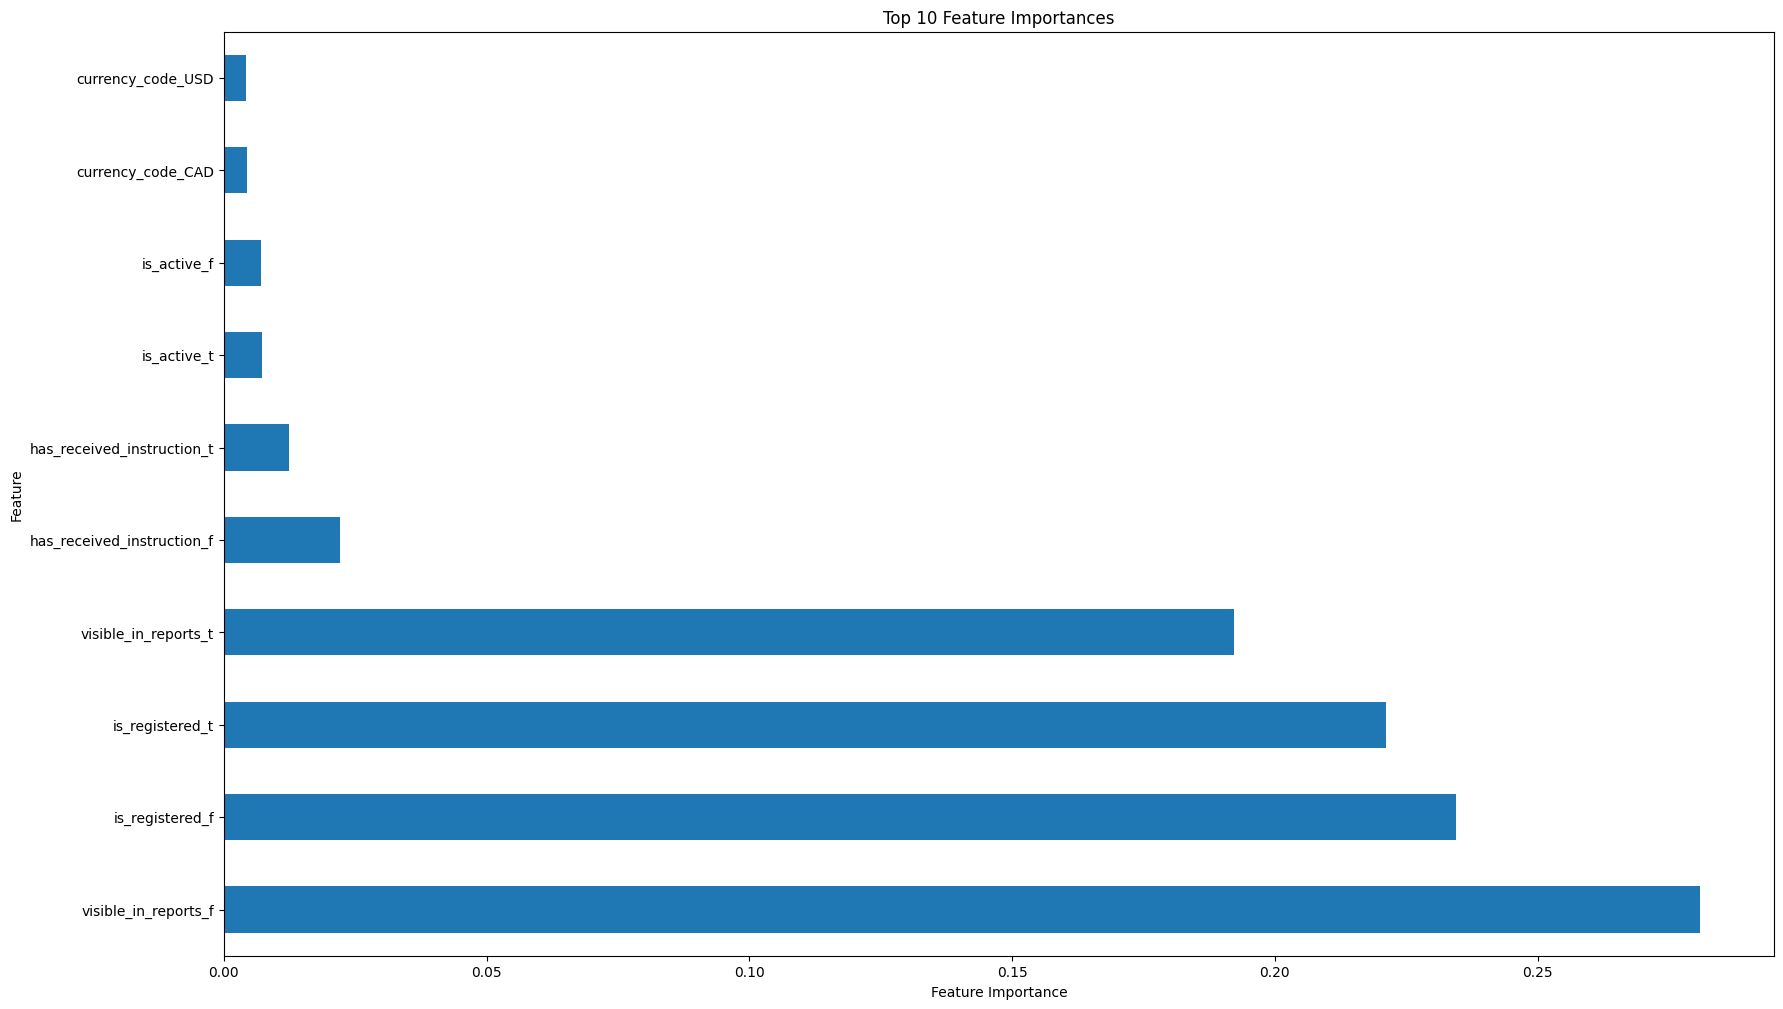

In [54]:
plt.figure(figsize=(20, 12))
feature_importances = pd.Series(no_nan_data_model.feature_importances_, index = no_nan_cols_no_time_series_dummies.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

This simple Random Forest Classifier did a decent job. As we analyze using our domain knowledge, if a client is **not visible in reports**, it may indicate that the client has been inactive for a long time, leading to the churn decision of that client.

#### Evaluate the importance of each feature to the target

In [55]:
auc_scores = []
roc_curves = []

for feature in no_nan_cols_no_time_series_dummies.columns:
    _feature = no_nan_cols_no_time_series_dummies[[feature]]
    no_nan_data_model.fit(_feature, rf_label)
    
    y_pred = no_nan_data_model.predict_proba(_feature)[:, 1]
    
    fpr, tpr, _ = roc_curve(rf_label, y_pred)
    roc_curves.append((fpr, tpr))
    
    auc_score = auc(fpr, tpr)
    auc_scores.append(auc_score)

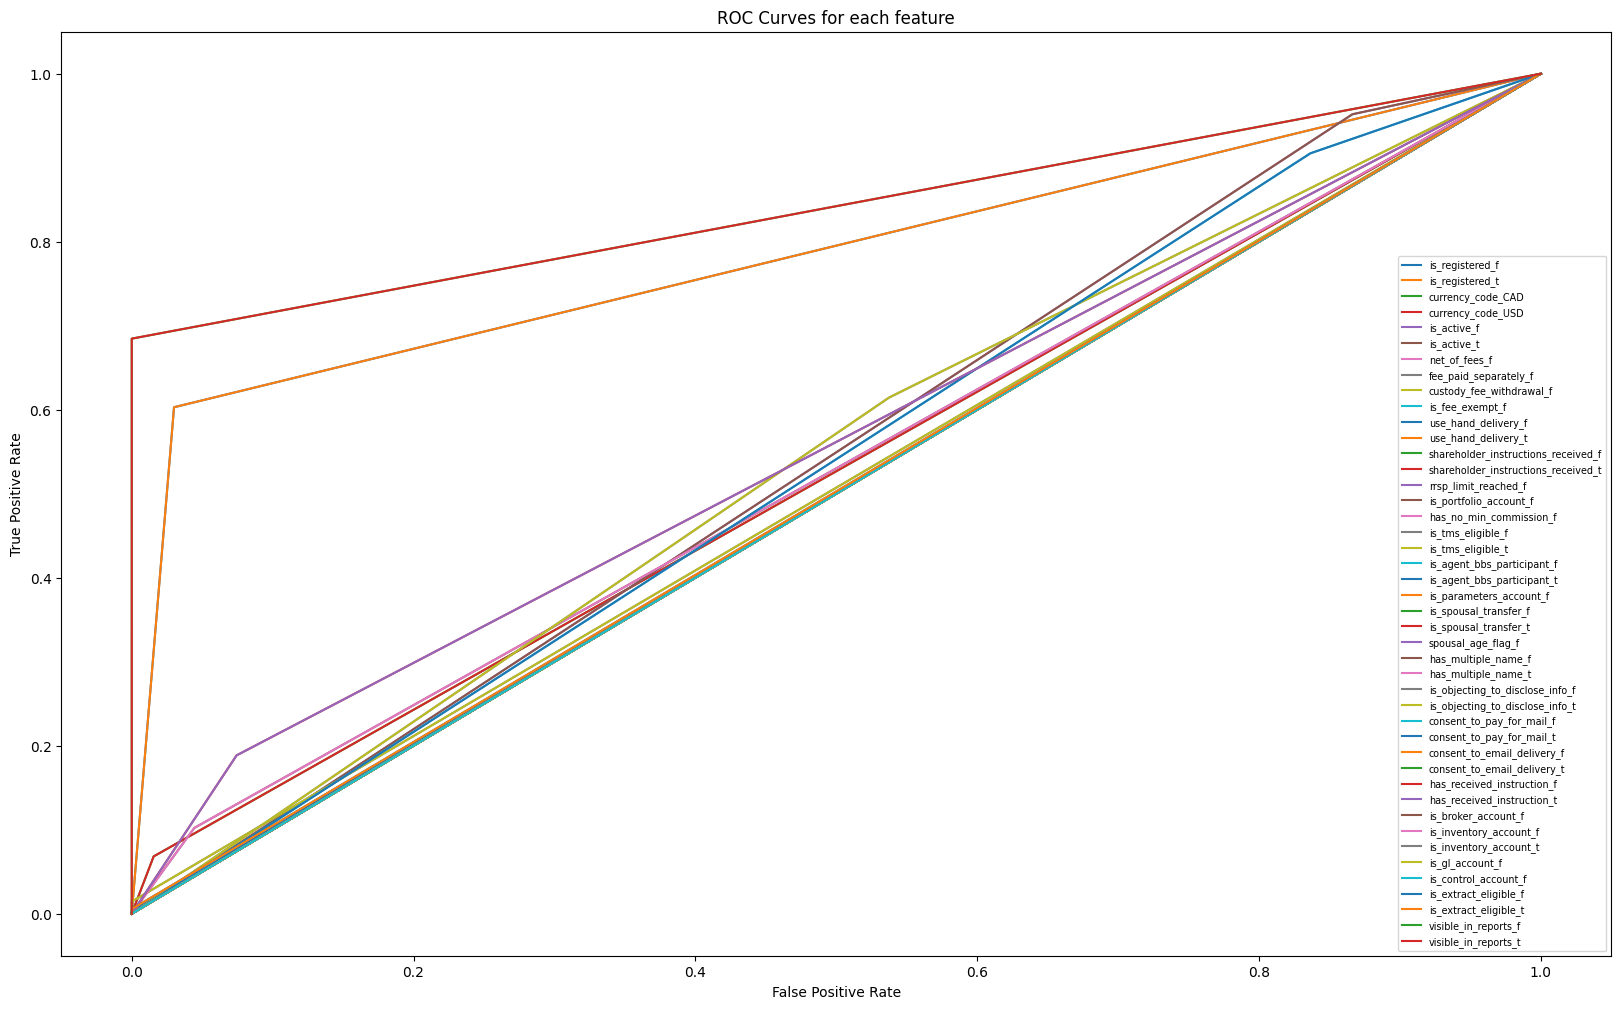

In [56]:
plt.figure(figsize=(20, 12))
for fpr, tpr in roc_curves:
    plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each feature')
plt.legend(no_nan_cols_no_time_series_dummies.columns, loc='lower right', fontsize='x-small')
plt.show()

In [57]:
# print AUC score for each feature
for i, feature in enumerate(no_nan_cols_no_time_series_dummies.columns):
    print(f"Feature '{feature}': AUC = {auc_scores[i]}")

Feature 'is_registered_f': AUC = 0.7864644294739092
Feature 'is_registered_t': AUC = 0.7864644294739092
Feature 'currency_code_CAD': AUC = 0.526330192205018
Feature 'currency_code_USD': AUC = 0.526330192205018
Feature 'is_active_f': AUC = 0.5427176541179999
Feature 'is_active_t': AUC = 0.5427176541179999
Feature 'net_of_fees_f': AUC = 0.5
Feature 'fee_paid_separately_f': AUC = 0.5
Feature 'custody_fee_withdrawal_f': AUC = 0.5
Feature 'is_fee_exempt_f': AUC = 0.5
Feature 'use_hand_delivery_f': AUC = 0.5000130317038161
Feature 'use_hand_delivery_t': AUC = 0.5000130317038161
Feature 'shareholder_instructions_received_f': AUC = 0.5003157166115435
Feature 'shareholder_instructions_received_t': AUC = 0.5003157166115435
Feature 'rrsp_limit_reached_f': AUC = 0.5
Feature 'is_portfolio_account_f': AUC = 0.5
Feature 'has_no_min_commission_f': AUC = 0.5
Feature 'is_tms_eligible_f': AUC = 0.5071957343753483
Feature 'is_tms_eligible_t': AUC = 0.5071957343753483
Feature 'is_agent_bbs_participant_f': 

Question: Should we drop features based solely on AUC score of each feature?

In [58]:
#### Rule of thumb for "good" AUC score

# Each feature with an AUC score above 0.7 would be considered acceptable, therefore any features with AUC score < 0.7 would be considered for removing.

# df_copy = df_copy.drop(['currency_code', 'is_active', 'net_of_fees', 'fee_paid_separately', 'custody_fee_withdrawal', 'is_fee_exempt', 'use_hand_delivery', 'shareholder_instructions_received', 
#                         'rrsp_limit_reached', 'is_portfolio_account', 'has_no_min_commission', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_parameters_account', 'is_spousal_transfer', 
#                         'spousal_age_flag', 'has_multiple_name', 'is_objecting_to_disclose_info', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_broker_account', 
#                         'is_inventory_account', 'is_gl_account', 'is_control_account', 'is_extract_eligible'], axis=1)

In [59]:
# no_nan_cols_no_time_series_dummies = no_nan_cols_no_time_series_dummies.drop(['currency_code_CAD', 'currency_code_USD', 'is_active_f', 'is_active_t', 'net_of_fees_f',
#                                                                               'fee_paid_separately_f', 'custody_fee_withdrawal_f', 'is_fee_exempt_f', 
#                                                                               'use_hand_delivery_f', 'use_hand_delivery_t', 'shareholder_instructions_received_f', 'shareholder_instructions_received_t',
#                                                                               'rrsp_limit_reached_f', 'is_portfolio_account_f', 'has_no_min_commission_f',
#                                                                               'is_tms_eligible_f', 'is_tms_eligible_t', 'is_agent_bbs_participant_f', 'is_agent_bbs_participant_t', 'is_parameters_account_f',
#                                                                               'is_spousal_transfer_f', 'is_spousal_transfer_t', 'spousal_age_flag_f', 'has_multiple_name_f', 'has_multiple_name_t',
#                                                                               'is_objecting_to_disclose_info_f', 'is_objecting_to_disclose_info_t', 'consent_to_pay_for_mail_f', 'consent_to_pay_for_mail_t',
#                                                                               'consent_to_email_delivery_f', 'consent_to_email_delivery_t', 'has_received_instruction_f', 'has_received_instruction_t',
#                                                                               'is_broker_account_f', 'is_inventory_account_f', 'is_inventory_account_t', 'is_gl_account_f',
#                                                                               'is_control_account_f', 'is_extract_eligible_f', 'is_extract_eligible_t'], axis=1)

In [60]:
no_nan_cols_no_time_series_dummies

is_registered_f  is_registered_t  currency_code_CAD  \
0                  True            False               True   
1                 False             True               True   
2                 False             True               True   
3                  True            False               True   
4                  True            False               True   
...                 ...              ...                ...   
673334            False             True               True   
673335            False             True               True   
673336             True            False               True   
673337            False             True               True   
673338             True            False               True   

        currency_code_USD  is_active_f  is_active_t  net_of_fees_f  \
0                   False        False         True           True   
1                   False        False         True           True   
2                   False        False         True           True   
3                   False        False         True           True   
4                   False        False         True           True   
...                   ...          ...          ...            ...   
673334              False        False         True           True   
673335              False         True        False           True   
673336              False        False         True           True   
673337              False        False         True           True   
673338              False        False         True           True   

        fee_paid_separately_f  custody_fee_withdrawal_f  is_fee_exempt_f  \
0                        True                      True             True   
1                        True                      True             True   
2                        True                      True             True   
3                        True                      True             True   
4                        True                      True             True   
...                       ...                       ...              ...   
673334                   True                      True             True   
673335                   True                      True             True   
673336                   True                      True             True   
673337                   True                      True             True   
673338                   True                      True             True   

        use_hand_delivery_f  use_hand_delivery_t  \
0                      True                False   
1                      True                False   
2                      True                False   
3                      True                False   
4                      True                False   
...                     ...                  ...   
673334                 True                False   
673335                 True                False   
673336                 True                False   
673337                 True                False   
673338                 True                False   

        shareholder_instructions_received_f  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                      True   
...                                     ...   
673334                                 True   
673335                                 True   
673336                                 True   
673337                                 True   
673338                                 True   

        shareholder_instructions_received_t  rrsp_limit_reached_f  \
0                                     False                  True   
1                                     False                  True   
2                                     False                  True   
3                              

As clustering on the above data would cause huge time complexity and resources, we have to perform some dimensionality reduction techniques such as PCA to extract new set of features that bring most variance (retain the original information) of our dataset.

### PCA

In [61]:
no_nan_cols_dummies_train = np.array(no_nan_cols_no_time_series_dummies).astype(np.float32)

In [62]:
no_nan_cols_dummies_train

array([[1., 0., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]], dtype=float32)

In [63]:
cov_mat = np.cov(no_nan_cols_dummies_train.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print(f"Eigenvalues: \n {eigen_vals}")
print(f"Eigenvalues shape: {eigen_vals.shape}")

Eigenvalues: 
 [ 6.84846730e-01+0.00000000e+00j  5.08441652e-01+0.00000000e+00j
  4.60265278e-01+0.00000000e+00j  1.92887068e-01+0.00000000e+00j
  1.51307440e-01+0.00000000e+00j  1.40998398e-01+0.00000000e+00j
  1.01926758e-01+0.00000000e+00j  1.02606643e-01+0.00000000e+00j
  2.22579684e-02+0.00000000e+00j  9.46238623e-03+0.00000000e+00j
  5.97636865e-03+0.00000000e+00j  3.48047384e-03+0.00000000e+00j
  4.42210839e-04+0.00000000e+00j  3.67973611e-04+0.00000000e+00j
  3.05345905e-04+0.00000000e+00j  9.92686318e-05+0.00000000e+00j
 -8.97755503e-18+1.51656694e-17j -8.97755503e-18-1.51656694e-17j
  1.39218458e-17+0.00000000e+00j -1.26362009e-18+1.79900133e-18j
 -1.26362009e-18-1.79900133e-18j  1.87878340e-18+7.42925052e-19j
  1.87878340e-18-7.42925052e-19j -1.26951048e-18+0.00000000e+00j
  1.01444321e-18+0.00000000e+00j -5.18112782e-19+0.00000000e+00j
 -3.88409724e-19+0.00000000e+00j  1.75361396e-19+0.00000000e+00j
  1.19050461e-19+0.00000000e+00j  4.73672514e-20+0.00000000e+00j
 -3.449358

In [64]:
def explain_variance(eigenvalues):
    '''
        Plot how many PCA axes needed to explain most variance
        from the original feature space of our dataset
    '''
    var_explained = []
    total = sum(eigenvalues)
    for i in sorted(eigenvalues, reverse=True):
        var = i / total
        var_explained.append(var)
    cummulative_var_explained = np.cumsum(var_explained)
    plt.bar(range(1, len(eigenvalues)+1), var_explained, alpha=0.5, align='center', label='Individual explained variance ratio')
    plt.step(range(1, len(eigenvalues)+1), cummulative_var_explained, where='mid', label='Cummulative explained ratio')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


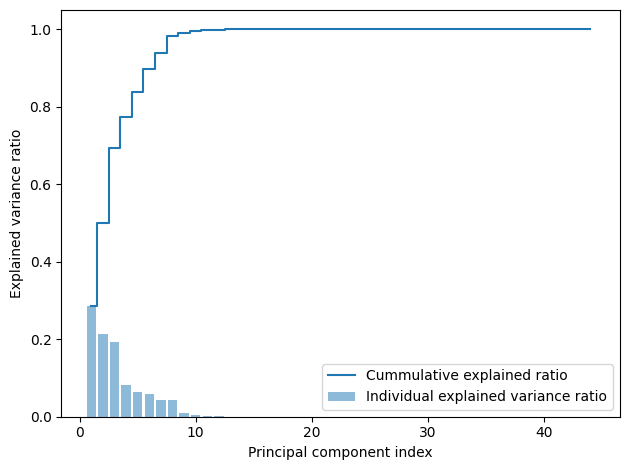

In [65]:
explain_variance(eigen_vals)

As we can see, with the number of PCA axes of 10 axes, they already explained almost 100% of the variance of the original data. We will pick 10 as the number of clusters for our SBM disussed later on.

Since the objective is to classify whether a user churned or didn't churn from the service, so we have to drop the plan_end_date column. However, I will go into detail about my approach towards the Customer Churn problem after dealing with data processing.

In [66]:
df_copy = df_copy.drop('plan_end_date', axis=1)

We have extracted 10 PCA axes as the ideal number of clusters for our clustering algorithm for the non-null dataset.

In [67]:
no_nan_cols_no_time_series_dummies

is_registered_f  is_registered_t  currency_code_CAD  \
0                  True            False               True   
1                 False             True               True   
2                 False             True               True   
3                  True            False               True   
4                  True            False               True   
...                 ...              ...                ...   
673334            False             True               True   
673335            False             True               True   
673336             True            False               True   
673337            False             True               True   
673338             True            False               True   

        currency_code_USD  is_active_f  is_active_t  net_of_fees_f  \
0                   False        False         True           True   
1                   False        False         True           True   
2                   False        False         True           True   
3                   False        False         True           True   
4                   False        False         True           True   
...                   ...          ...          ...            ...   
673334              False        False         True           True   
673335              False         True        False           True   
673336              False        False         True           True   
673337              False        False         True           True   
673338              False        False         True           True   

        fee_paid_separately_f  custody_fee_withdrawal_f  is_fee_exempt_f  \
0                        True                      True             True   
1                        True                      True             True   
2                        True                      True             True   
3                        True                      True             True   
4                        True                      True             True   
...                       ...                       ...              ...   
673334                   True                      True             True   
673335                   True                      True             True   
673336                   True                      True             True   
673337                   True                      True             True   
673338                   True                      True             True   

        use_hand_delivery_f  use_hand_delivery_t  \
0                      True                False   
1                      True                False   
2                      True                False   
3                      True                False   
4                      True                False   
...                     ...                  ...   
673334                 True                False   
673335                 True                False   
673336                 True                False   
673337                 True                False   
673338                 True                False   

        shareholder_instructions_received_f  \
0                                      True   
1                                      True   
2                                      True   
3                                      True   
4                                      True   
...                                     ...   
673334                                 True   
673335                                 True   
673336                                 True   
673337                                 True   
673338                                 True   

        shareholder_instructions_received_t  rrsp_limit_reached_f  \
0                                     False                  True   
1                                     False                  True   
2                                     False                  True   
3                              

In [68]:
# cluster the data with the number of clusters = 10
optimal_num_clusters = 10
kmode_optimal = KModes(n_clusters = optimal_num_clusters, init = 'Cao', n_init = 1, verbose = 1)          # applied K-modes clustering for categorical data
clusters = kmode_optimal.fit_predict(no_nan_cols_no_time_series_dummies)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 136556, cost: 1192752.0
Run 1, iteration: 2/100, moves: 9632, cost: 1192144.0
Run 1, iteration: 3/100, moves: 97, cost: 1192144.0


In [69]:
np.unique(clusters)             # 10 unique clusters

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

In [70]:
df_copy['Clusters'] = clusters

In [71]:
df_copy

id       type_code is_registered currency_code is_active  \
0        893724      CASH SWEEP             f           CAD         t   
1       1268094            RRIF             t           CAD         t   
2        606613    SPOUSAL RRSP             t           CAD         t   
3        741930            CASH             f           CAD         t   
4       1137922            CASH             f           CAD         t   
...         ...             ...           ...           ...       ...   
673334  6827067  LIRA/LRSP/RLSP             t           CAD         t   
673335   590659        REG RRSP             t           CAD         f   
673336  1247774            CASH             f           CAD         t   
673337  1155640            RRIF             t           CAD         t   
673338  1148378      CASH SWEEP             f           CAD         t   

        class_id debit_code last_trade_date  contract_type inception_date  \
0            3.0          0             NaN            NaN     2017-08-18   
1            5.0          C      2022-07-04           18.0     2018-11-08   
2            5.0          A      2018-07-05           16.0     2009-04-08   
3            3.0          T             NaN           12.0     2021-01-04   
4            3.0          T             NaN           17.0     2017-07-21   
...          ...        ...             ...            ...            ...   
673334       5.0          C             NaN           18.0     2023-06-27   
673335       5.0          A      2017-06-28           18.0     2006-11-23   
673336       3.0          T      2021-09-24           16.0     2019-08-30   
673337       5.0          C             NaN           17.0     2017-07-21   
673338       3.0          A             NaN            NaN     2017-08-18   

       net_of_fees fee_paid_separately custody_fee_withdrawal is_fee_exempt  \
0                f                   f                      f             f   
1                f                   f                      f             f   
2                f                   f                      f             f   
3                f                   f                      f             f   
4                f                   f                      f             f   
...            ...                 ...                    ...           ...   
673334           f                   f                      f             f   
673335           f                   f                      f             f   
673336           f                   f                      f             f   
673337           f                   f                      f             f   
673338           f                   f                      f             f   

       branch  credit_limit_type retail_plan is_spousal is_arp_locked  \
0        IAVM                0.0         NaN        NaN           NaN   
1        IAVM                0.0          RI          f             f   
2        IAVM                0.0          RS          t             f   
3        IAVM                0.0         NaN        NaN           NaN   
4        IAVM                0.0         NaN        NaN           NaN   
...       ...                ...         ...        ...           ...   
673334  HOLIS                0.0          RS          f             t   
673335   IAVM                0.0          RS          f             f   
673336   IAVM                0.0         NaN        NaN           NaN   
673337   IAVM                0.0          RI          f             f   
673338   IAVM                0.0         NaN        NaN           NaN   

       arp_pension_origin language_code  dividend_confirm_code sss_location  \
0                     NaN             E                    0.0          NaN   
1                     NaN             E                    0.0          NaN   
2                     NaN             F                    0.0          NaN   
3                     NaN             E                    0.0       

In [72]:
# check if all records per cluster add up to the original number of records
rec_count = 0
for i in range(len(np.unique(clusters))):
    rec_count = rec_count + len(df_copy.loc[df_copy['Clusters'] == i])

In [73]:
rec_count

673339

### Filling missing values
Each record in our original dataset (containing null values) has been assigned to each of the 10 clusters. We proceed with filling null values by the mode of each column corresponding to each null value and the cluster number.

In [74]:
# if the cluster is 0, then loop over every column within each record corresponding to cluster 0. The same thing with other clusters
def fill_nan_by_mode(data, cluster_col):
    '''
        Fill null values by the mode of each column
        corresponding to each null value and cluster number
        
        data: DataFrame
        cluster_col: name of the cluster column
    '''
    for cluster_num in data[cluster_col].unique():
        cluster_data = data[data[cluster_col] == cluster_num]
        
        # fill null values with mode for each cluster
        cluster_mode = cluster_data.mode().iloc[0]       # select the first row and calculate the mode for each column in DataFrame, the result is that row containing the mode value of each column
        data.loc[data[cluster_col] == cluster_num] = data.loc[data[cluster_col] == cluster_num].fillna(cluster_mode)
    return data

In [75]:
# # experimenting filling missing values by mode without considering the cluster
# def fill_nan_by_mode_no_clusters(data, cluster_col):
#     for col in data.columns:
#         cluster_mode = data[col].mode()[0]
#         data[col] = data[col].fillna(cluster_mode)
#     return data

In [76]:
df_copy = fill_nan_by_mode(df_copy, 'Clusters')

/tmp/ipykernel_18/58198470.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[data[cluster_col] == cluster_num] = data.loc[data[cluster_col] == cluster_num].fillna(cluster_mode)
/tmp/ipykernel_18/58198470.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[data[cluster_col] == cluster_num] = data.loc[data[cluster_col] == cluster_num].fillna(cluster_mode)
/tmp/ipykernel_18/58198470.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objec

In [77]:
# df_copy_3 = fill_nan_by_mode_no_clusters(df_copy_3, 'Clusters')

In [78]:
# df_copy_3   # this only fill the missing values of each column with its mode, which will cause bias for our model -> the method of filling missing values with mode of the column based on cluster works better

In [79]:
# print the number of null values for each column for df_copy2
for col in df_copy.columns:
    print(f"'{col}' nulls: {df_copy[col].isna().sum()}")

'id' nulls: 0
'type_code' nulls: 0
'is_registered' nulls: 0
'currency_code' nulls: 0
'is_active' nulls: 0
'class_id' nulls: 0
'debit_code' nulls: 0
'last_trade_date' nulls: 0
'contract_type' nulls: 0
'inception_date' nulls: 0
'net_of_fees' nulls: 0
'fee_paid_separately' nulls: 0
'custody_fee_withdrawal' nulls: 0
'is_fee_exempt' nulls: 0
'branch' nulls: 0
'credit_limit_type' nulls: 0
'retail_plan' nulls: 7427
'is_spousal' nulls: 7427
'is_arp_locked' nulls: 7427
'arp_pension_origin' nulls: 7427
'language_code' nulls: 0
'dividend_confirm_code' nulls: 0
'sss_location' nulls: 61269
'options_trading_type' nulls: 0
'sss_type' nulls: 61269
'sss_agent' nulls: 61269
'is_midwest_clearing_account' nulls: 0
'rep_commission_rate' nulls: 0
'rep_commission_override' nulls: 0
'interest_dividend_conversion_type' nulls: 0
'guarantee_gtor_type' nulls: 0
'use_hand_delivery' nulls: 0
'shareholder_instructions_received' nulls: 0
'rrsp_limit_reached' nulls: 0
'is_portfolio_account' nulls: 0
'has_no_min_commis

There are a lot of columns missing 7427 values, so we suspect that there are 7427 rows that contain missing values in those columns. Observe that there is 'tms_settlement_location' containing 186399 null values which take up a lot of our data, so we might consider dropping that column. After checking the description of this column, the settlement location doesn't really determine the churn behavior of a client (there are features that have stronger relationship to the churn behavior), thus we drop 'tms_settlement_location'. Also, for columns that contain less than 100000 null values, we will drop those null values since they aren't a huge part of our dataset. We perform these methods, then rerun the loop above to check for null values in each column.

In [80]:
for col in df_copy.columns:
    if df_copy[col].isna().sum() < 100000:
        df_copy.dropna(subset=[col], inplace=True)

In [81]:
df_copy = df_copy.drop('tms_settlement_location', axis=1)

In [82]:
df_copy          # clean df_copy, dataset contains 0 null values

id       type_code is_registered currency_code is_active  \
0        893724      CASH SWEEP             f           CAD         t   
1       1268094            RRIF             t           CAD         t   
3        741930            CASH             f           CAD         t   
5       1020597        REG RRSP             t           CAD         t   
6        664230            CASH             f           CAD         t   
...         ...             ...           ...           ...       ...   
673333   574623        REG RRSP             t           CAD         t   
673334  6827067  LIRA/LRSP/RLSP             t           CAD         t   
673335   590659        REG RRSP             t           CAD         f   
673337  1155640            RRIF             t           CAD         t   
673338  1148378      CASH SWEEP             f           CAD         t   

        class_id debit_code last_trade_date  contract_type inception_date  \
0            3.0          0      2018-07-06           18.0     2017-08-18   
1            5.0          C      2022-07-04           18.0     2018-11-08   
3            3.0          T      2022-12-16           12.0     2021-01-04   
5            5.0          C      2021-09-10            9.0     2017-07-21   
6            3.0          T      2022-12-16            9.0     2016-12-02   
...          ...        ...             ...            ...            ...   
673333       5.0          C      2022-12-16            9.0     2023-02-09   
673334       5.0          C      2022-12-16           18.0     2023-06-27   
673335       5.0          A      2017-06-28           18.0     2006-11-23   
673337       5.0          C      2022-12-16           17.0     2017-07-21   
673338       3.0          A      2018-07-06           18.0     2017-08-18   

       net_of_fees fee_paid_separately custody_fee_withdrawal is_fee_exempt  \
0                f                   f                      f             f   
1                f                   f                      f             f   
3                f                   f                      f             f   
5                f                   f                      f             f   
6                f                   f                      f             f   
...            ...                 ...                    ...           ...   
673333           f                   f                      f             f   
673334           f                   f                      f             f   
673335           f                   f                      f             f   
673337           f                   f                      f             f   
673338           f                   f                      f             f   

       branch  credit_limit_type retail_plan is_spousal is_arp_locked  \
0        IAVM                0.0          RS          f             f   
1        IAVM                0.0          RI          f             f   
3        IAVM                0.0          RS          f             f   
5        IAVM                0.0          RS          f             f   
6        IAVM                0.0          RS          f             f   
...       ...                ...         ...        ...           ...   
673333    IAS                0.0          RS          f             f   
673334  HOLIS                0.0          RS          f             t   
673335   IAVM                0.0          RS          f             f   
673337   IAVM                0.0          RI          f             f   
673338   IAVM                0.0          RS          f             f   

       arp_pension_origin language_code  dividend_confirm_code sss_location  \
0                      ON             E                    0.0            T   
1                      ON             E                    0.0            T   
3                      ON             E                    0.0            T   
5                      ON             E                    0.0       

In [83]:
# print the number of null values for each column for df_copy2
for col in df_copy.columns:
    print(f"'{col}' nulls: {df_copy[col].isna().sum()}")

'id' nulls: 0
'type_code' nulls: 0
'is_registered' nulls: 0
'currency_code' nulls: 0
'is_active' nulls: 0
'class_id' nulls: 0
'debit_code' nulls: 0
'last_trade_date' nulls: 0
'contract_type' nulls: 0
'inception_date' nulls: 0
'net_of_fees' nulls: 0
'fee_paid_separately' nulls: 0
'custody_fee_withdrawal' nulls: 0
'is_fee_exempt' nulls: 0
'branch' nulls: 0
'credit_limit_type' nulls: 0
'retail_plan' nulls: 0
'is_spousal' nulls: 0
'is_arp_locked' nulls: 0
'arp_pension_origin' nulls: 0
'language_code' nulls: 0
'dividend_confirm_code' nulls: 0
'sss_location' nulls: 0
'options_trading_type' nulls: 0
'sss_type' nulls: 0
'sss_agent' nulls: 0
'is_midwest_clearing_account' nulls: 0
'rep_commission_rate' nulls: 0
'rep_commission_override' nulls: 0
'interest_dividend_conversion_type' nulls: 0
'guarantee_gtor_type' nulls: 0
'use_hand_delivery' nulls: 0
'shareholder_instructions_received' nulls: 0
'rrsp_limit_reached' nulls: 0
'is_portfolio_account' nulls: 0
'has_no_min_commission' nulls: 0
'is_tms_e

Each client has a unique ID, but since the default index column in pandas contains unique indices as well for each record (client), we should drop the 'id' column to reduce the dimension of the encoded dataset later on, as every value in the ID column is unique so there will be many categories when decoding.

In [84]:
df_copy = df_copy.drop('id', axis=1)

In [85]:
df_copy.reset_index(drop=True, inplace=True)

In [86]:
df_copy = df_copy.drop(['plan_effective_date'], axis=1)                                  # drop plan_effective_date, since inception_date dates come first
df_copy_time_based_cols = df_copy_time_based_cols.drop(['plan_end_date', 'plan_effective_date'], axis=1)

In [87]:
# convert date time to just year month day
for col in df_copy_time_based_cols.columns:
    df_copy[col] = pd.to_datetime(df_copy[col])

In [88]:
df_copy

type_code is_registered currency_code is_active  class_id  \
0           CASH SWEEP             f           CAD         t       3.0   
1                 RRIF             t           CAD         t       5.0   
2                 CASH             f           CAD         t       3.0   
3             REG RRSP             t           CAD         t       5.0   
4                 CASH             f           CAD         t       3.0   
...                ...           ...           ...       ...       ...   
521308        REG RRSP             t           CAD         t       5.0   
521309  LIRA/LRSP/RLSP             t           CAD         t       5.0   
521310        REG RRSP             t           CAD         f       5.0   
521311            RRIF             t           CAD         t       5.0   
521312      CASH SWEEP             f           CAD         t       3.0   

       debit_code last_trade_date  contract_type inception_date net_of_fees  \
0               0      2018-07-06           18.0     2017-08-18           f   
1               C      2022-07-04           18.0     2018-11-08           f   
2               T      2022-12-16           12.0     2021-01-04           f   
3               C      2021-09-10            9.0     2017-07-21           f   
4               T      2022-12-16            9.0     2016-12-02           f   
...           ...             ...            ...            ...         ...   
521308          C      2022-12-16            9.0     2023-02-09           f   
521309          C      2022-12-16           18.0     2023-06-27           f   
521310          A      2017-06-28           18.0     2006-11-23           f   
521311          C      2022-12-16           17.0     2017-07-21           f   
521312          A      2018-07-06           18.0     2017-08-18           f   

       fee_paid_separately custody_fee_withdrawal is_fee_exempt branch  \
0                        f                      f             f   IAVM   
1                        f                      f             f   IAVM   
2                        f                      f             f   IAVM   
3                        f                      f             f   IAVM   
4                        f                      f             f   IAVM   
...                    ...                    ...           ...    ...   
521308                   f                      f             f    IAS   
521309                   f                      f             f  HOLIS   
521310                   f                      f             f   IAVM   
521311                   f                      f             f   IAVM   
521312                   f                      f             f   IAVM   

        credit_limit_type retail_plan is_spousal is_arp_locked  \
0                     0.0          RS          f             f   
1                     0.0          RI          f             f   
2                     0.0          RS          f             f   
3                     0.0          RS          f             f   
4                     0.0          RS          f             f   
...                   ...         ...        ...           ...   
521308                0.0          RS          f             f   
521309                0.0          RS          f             t   
521310                0.0          RS          f             f   
521311                0.0          RI          f             f   
521312                0.0          RS          f             f   

       arp_pension_origin language_code  dividend_confirm_code sss_location  \
0                      ON             E                    0.0            T   
1                      ON             E                    0.0            T   
2                      ON             E                    0.0            T   
3                      ON             E                    0.0            T   
4                      ON             E                    0.0            T   
...                

In [89]:
# get the label column to assign to target outcome later on
label_ = df_copy['label']

In [90]:
# make a copy of df_copy containing Clusters, then drop the Clusters column from df_copy
df_copy_with_clusters = df_copy[:]

In [91]:
df_copy = df_copy.drop(['label', 'Clusters'], axis=1)

In [92]:
# check the number of categories per column
total_categories = 0
for col in df_copy.columns:
    print(f"Number of categories in '{col}': {len(df_copy[col].unique())}")
    total_categories += len(df_copy[col].unique())
print(f"Total number of categories: {total_categories}")

Number of categories in 'type_code': 20
Number of categories in 'is_registered': 2
Number of categories in 'currency_code': 2
Number of categories in 'is_active': 2
Number of categories in 'class_id': 52
Number of categories in 'debit_code': 20
Number of categories in 'last_trade_date': 4553
Number of categories in 'contract_type': 19
Number of categories in 'inception_date': 5609
Number of categories in 'net_of_fees': 1
Number of categories in 'fee_paid_separately': 1
Number of categories in 'custody_fee_withdrawal': 1
Number of categories in 'is_fee_exempt': 1
Number of categories in 'branch': 9
Number of categories in 'credit_limit_type': 3
Number of categories in 'retail_plan': 9
Number of categories in 'is_spousal': 2
Number of categories in 'is_arp_locked': 2
Number of categories in 'arp_pension_origin': 12
Number of categories in 'language_code': 2
Number of categories in 'dividend_confirm_code': 4
Number of categories in 'sss_location': 2
Number of categories in 'options_tradin

### Encoding dataset: Binary encoding
There are time-series features that contain a lot of different categories (time, hour). If we chose to perform one-hot encoding, it may cause a very large dataset and there will not be enough memory. Binary Encoding is the alternative.

In [93]:
binary_encoder = ce.BinaryEncoder(cols=list(df_copy.columns), return_df=True)

In [94]:
df_copy_encoded = binary_encoder.fit_transform(df_copy)
df_copy_encoded    # encode df_copy

/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change 

type_code_0  type_code_1  type_code_2  type_code_3  type_code_4  \
0                 0            0            0            0            1   
1                 0            0            0            1            0   
2                 0            0            0            1            1   
3                 0            0            1            0            0   
4                 0            0            0            1            1   
...             ...          ...          ...          ...          ...   
521308            0            0            1            0            0   
521309            0            1            0            0            0   
521310            0            0            1            0            0   
521311            0            0            0            1            0   
521312            0            0            0            0            1   

        is_registered_0  is_registered_1  currency_code_0  currency_code_1  \
0                     0                1                0                1   
1                     1                0                0                1   
2                     0                1                0                1   
3                     1                0                0                1   
4                     0                1                0                1   
...                 ...              ...              ...              ...   
521308                1                0                0                1   
521309                1                0                0                1   
521310                1                0                0                1   
521311                1                0                0                1   
521312                0                1                0                1   

        is_active_0  is_active_1  class_id_0  class_id_1  class_id_2  \
0                 0            1           0           0           0   
1                 0            1           0           0           0   
2                 0            1           0           0           0   
3                 0            1           0           0           0   
4                 0            1           0           0           0   
...             ...          ...         ...         ...         ...   
521308            0            1           0           0           0   
521309            0            1           0           0           0   
521310            1            0           0           0           0   
521311            0            1           0           0           0   
521312            0            1           0           0           0   

        class_id_3  class_id_4  class_id_5  debit_code_0  debit_code_1  \
0                0           0           1             0             0   
1                0           1           0             0             0   
2                0           0           1             0             0   
3                0           1           0             0             0   
4                0           0           1             0             0   
...            ...         ...         ...           ...           ...   
521308           0           1           0             0             0   
521309           0           1           0             0             0   
521310           0           1           0             0             0   
521311           0           1           0             0             0   
521312           0           0           1             0             0   

        debit_code_2  debit_code_3  debit_code_4  last_trade_date_0  \
0                  0             0             1                  0   
1                  0             1             0                  0   
2                  0             1             1                  0   
3                  0             1             0                  0   
4                  0             1             1             

In [95]:
# correlation between features
corr_matrix_ = df_copy_encoded.corr()
corr_matrix_

type_code_0  type_code_1  type_code_2  \
type_code_0                        1.000000    -0.013014    -0.029932   
type_code_1                       -0.013014     1.000000    -0.115294   
type_code_2                       -0.029932    -0.115294     1.000000   
type_code_3                       -0.007919    -0.334595    -0.116882   
type_code_4                       -0.019780    -0.040509    -0.629180   
...                                     ...          ...          ...   
retail_last_maintenance_user_6    -0.019848     0.034497     0.424573   
retail_last_maintenance_user_7     0.002459     0.021915     0.239159   
retail_last_maintenance_user_8     0.013861    -0.007920    -0.326389   
visible_in_reports_0              -0.021006     0.018856     0.079442   
visible_in_reports_1               0.021006    -0.018856    -0.079442   

                                type_code_3  type_code_4  is_registered_0  \
type_code_0                       -0.007919    -0.019780        -0.035984   
type_code_1                       -0.334595    -0.040509        -0.024529   
type_code_2                       -0.116882    -0.629180         0.755537   
type_code_3                        1.000000     0.065416        -0.051420   
type_code_4                        0.065416     1.000000        -0.819120   
...                                     ...          ...              ...   
retail_last_maintenance_user_6    -0.019043    -0.483921         0.506094   
retail_last_maintenance_user_7     0.002756    -0.251233         0.265576   
retail_last_maintenance_user_8     0.028875     0.342545        -0.363091   
visible_in_reports_0               0.194770    -0.088454         0.096476   
visible_in_reports_1              -0.194770     0.088454        -0.096476   

                                is_registered_1  currency_code_0  \
type_code_0                            0.035984         0.014194   
type_code_1                            0.024529         0.070259   
type_code_2                           -0.755537        -0.042523   
type_code_3                            0.051420         0.057749   
type_code_4                            0.819120         0.055609   
...                                         ...              ...   
retail_last_maintenance_user_6        -0.506094        -0.047276   
retail_last_maintenance_user_7        -0.265576        -0.003534   
retail_last_maintenance_user_8         0.363091         0.014977   
visible_in_reports_0                  -0.096476         0.054504   
visible_in_reports_1                   0.096476        -0.054504   

                                currency_code_1  is_active_0  is_active_1  \
type_code_0                           -0.014194     0.020074    -0.020074   
type_code_1                           -0.070259     0.029098    -0.029098   
type_code_2                            0.042523     0.024969    -0.024969   
type_code_3                           -0.057749    -0.042520     0.042520   
type_code_4                           -0.055609    -0.034188     0.034188   
...                                         ...          ...          ...   
retail_last_maintenance_user_6         0.047276    -0.104615     0.104615   
retail_last_maintenance_user_7         0.003534     0.280431    -0.280431   
retail_last_maintenance_user_8        -0.014977     0.056753    -0.056753   
visible_in_reports_0                  -0.054504    -0.310137     0.310137   
visible_in_reports_1                   0.054504     0.310137    -0.310137   

                                class_id_0  class_id_1  class_id_2  \
type_code_0                       0.019058    0.083459    0.182010   
type_code_1                       0.000928   -0.004262   -0.003831   
type_code_2                      -0.007601   -0.018510   -0.047180   
type_code_3                       0.003055    0.006898    0.036345   
type_code_4                       0.007247    0.018825    0.036699   
...                                    ...         ...         ...  

### Correlations between pairs of features that exceed the correlation threshold

In [96]:
corr_thresh_ = 0.7

corr_pairs_ = []
for i in range(len(corr_matrix_.columns)):
    for j in range(i+1, len(corr_matrix_.columns)):
        if abs(corr_matrix_.iloc[i, j] > corr_thresh_):
            corr_pairs_.append((corr_matrix_.columns[i], corr_matrix_.columns[j], corr_matrix_.iloc[i, j]))

for pair in corr_pairs_:
    print(f"Features '{pair[0]}' and '{pair[1]}' have correlation of: '{pair[2]}'")

Features 'type_code_2' and 'is_registered_0' have correlation of: '0.7555371431650169'
Features 'type_code_2' and 'class_id_4' have correlation of: '0.7617452583729405'
Features 'type_code_2' and 'guarantee_gtor_type_1' have correlation of: '0.7647550260596463'
Features 'type_code_4' and 'is_registered_1' have correlation of: '0.8191196382836503'
Features 'type_code_4' and 'class_id_5' have correlation of: '0.8556496566369153'
Features 'type_code_4' and 'guarantee_gtor_type_2' have correlation of: '0.8491777074500036'
Features 'type_code_4' and 'updated_at_7' have correlation of: '0.7484977008771525'
Features 'is_registered_0' and 'class_id_4' have correlation of: '0.9161362607775003'
Features 'is_registered_0' and 'guarantee_gtor_type_1' have correlation of: '0.9146896578765212'
Features 'is_registered_0' and 'updated_at_6' have correlation of: '0.8135982757047249'
Features 'is_registered_1' and 'class_id_5' have correlation of: '0.9565665549304191'
Features 'is_registered_1' and 'deb

In [97]:
df_copy_encoded

type_code_0  type_code_1  type_code_2  type_code_3  type_code_4  \
0                 0            0            0            0            1   
1                 0            0            0            1            0   
2                 0            0            0            1            1   
3                 0            0            1            0            0   
4                 0            0            0            1            1   
...             ...          ...          ...          ...          ...   
521308            0            0            1            0            0   
521309            0            1            0            0            0   
521310            0            0            1            0            0   
521311            0            0            0            1            0   
521312            0            0            0            0            1   

        is_registered_0  is_registered_1  currency_code_0  currency_code_1  \
0                     0                1                0                1   
1                     1                0                0                1   
2                     0                1                0                1   
3                     1                0                0                1   
4                     0                1                0                1   
...                 ...              ...              ...              ...   
521308                1                0                0                1   
521309                1                0                0                1   
521310                1                0                0                1   
521311                1                0                0                1   
521312                0                1                0                1   

        is_active_0  is_active_1  class_id_0  class_id_1  class_id_2  \
0                 0            1           0           0           0   
1                 0            1           0           0           0   
2                 0            1           0           0           0   
3                 0            1           0           0           0   
4                 0            1           0           0           0   
...             ...          ...         ...         ...         ...   
521308            0            1           0           0           0   
521309            0            1           0           0           0   
521310            1            0           0           0           0   
521311            0            1           0           0           0   
521312            0            1           0           0           0   

        class_id_3  class_id_4  class_id_5  debit_code_0  debit_code_1  \
0                0           0           1             0             0   
1                0           1           0             0             0   
2                0           0           1             0             0   
3                0           1           0             0             0   
4                0           0           1             0             0   
...            ...         ...         ...           ...           ...   
521308           0           1           0             0             0   
521309           0           1           0             0             0   
521310           0           1           0             0             0   
521311           0           1           0             0             0   
521312           0           0           1             0             0   

        debit_code_2  debit_code_3  debit_code_4  last_trade_date_0  \
0                  0             0             1                  0   
1                  0             1             0                  0   
2                  0             1             1                  0   
3                  0             1             0                  0   
4                  0             1             1             

In [98]:
corr_thresh_ = 0.7

corr_pairs_ = []
corr_hash = {}

for i in range(len(corr_matrix_.columns)):
    for j in range(i+1, len(corr_matrix_.columns)):
        if abs(corr_matrix_.iloc[i, j] > corr_thresh_):
            corr_pairs_.append((corr_matrix_.columns[i], corr_matrix_.columns[j], corr_matrix_.iloc[i, j]))
            # if a feature appears at least 2 times when having high correlation with other features -> drop such features
            if corr_matrix_.columns[i] in corr_hash:
                df_copy_encoded = df_copy_encoded.drop(corr_matrix_.columns[i], axis=1)
                break
            else:
                corr_hash[corr_matrix_.columns[i]] = corr_matrix_.iloc[i, j]

In [99]:
df_copy_encoded

type_code_0  type_code_1  type_code_3  currency_code_0  \
0                 0            0            0                0   
1                 0            0            1                0   
2                 0            0            1                0   
3                 0            0            0                0   
4                 0            0            1                0   
...             ...          ...          ...              ...   
521308            0            0            0                0   
521309            0            1            0                0   
521310            0            0            0                0   
521311            0            0            1                0   
521312            0            0            0                0   

        currency_code_1  is_active_0  is_active_1  class_id_0  class_id_1  \
0                     1            0            1           0           0   
1                     1            0            1           0           0   
2                     1            0            1           0           0   
3                     1            0            1           0           0   
4                     1            0            1           0           0   
...                 ...          ...          ...         ...         ...   
521308                1            0            1           0           0   
521309                1            0            1           0           0   
521310                1            1            0           0           0   
521311                1            0            1           0           0   
521312                1            0            1           0           0   

        class_id_2  class_id_3  debit_code_0  debit_code_1  debit_code_2  \
0                0           0             0             0             0   
1                0           0             0             0             0   
2                0           0             0             0             0   
3                0           0             0             0             0   
4                0           0             0             0             0   
...            ...         ...           ...           ...           ...   
521308           0           0             0             0             0   
521309           0           0             0             0             0   
521310           0           0             0             0             1   
521311           0           0             0             0             0   
521312           0           0             0             0             1   

        debit_code_3  debit_code_4  last_trade_date_0  last_trade_date_1  \
0                  0             1                  0                  0   
1                  1             0                  0                  0   
2                  1             1                  0                  0   
3                  1             0                  0                  0   
4                  1             1                  0                  0   
...              ...           ...                ...                ...   
521308             1             0                  0                  0   
521309             1             0                  0                  0   
521310             0             0                  0                  0   
521311             1             0                  0                  0   
521312             0             0                  0                  0   

        last_trade_date_2  last_trade_date_3  last_trade_date_4  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ..

In [100]:
# get the correlation between pair of features after excluding those with high correlation

corr_thresh_start = 0.5
corr_thresh_end = 0.7

corr_pairs_ = []
for i in range(len(corr_matrix_.columns)):
    for j in range(i+1, len(corr_matrix_.columns)):
        if abs(corr_matrix_.iloc[i, j] >= corr_thresh_start) and abs(corr_matrix_.iloc[i, j] <= corr_thresh_end):
            corr_pairs_.append((corr_matrix_.columns[i], corr_matrix_.columns[j], corr_matrix_.iloc[i, j]))

for pair in corr_pairs_:
    print(f"Features '{pair[0]}' and '{pair[1]}' have correlation of: '{pair[2]}'")

Features 'type_code_1' and 'retail_plan_1' have correlation of: '0.660844306704771'
Features 'type_code_1' and 'is_arp_locked_0' have correlation of: '0.5796692955951399'
Features 'type_code_2' and 'updated_at_6' have correlation of: '0.6787664623699985'
Features 'type_code_4' and 'debit_code_4' have correlation of: '0.6469748273153292'
Features 'is_registered_0' and 'retail_last_maintenance_user_6' have correlation of: '0.506093985210517'
Features 'is_registered_1' and 'special_fee_code_4' have correlation of: '0.5270911816924744'
Features 'class_id_4' and 'retail_plan_2' have correlation of: '0.5206567511032467'
Features 'class_id_4' and 'sss_agent_5' have correlation of: '0.5054993088204245'
Features 'class_id_4' and 'special_fee_code_3' have correlation of: '0.5053970146594501'
Features 'class_id_4' and 'resp_specimen_plan_1' have correlation of: '0.5011068308340548'
Features 'class_id_5' and 'special_fee_code_4' have correlation of: '0.5218198107639798'
Features 'debit_code_3' and

In [101]:
# get the list of features which have moderate correlation with other features
feat_corr_moderate = []
for i in range(len(corr_pairs_)):
    for j in range(len(corr_pairs_[i][:2])):
        if corr_pairs_[i][j] not in feat_corr_moderate:
            feat_corr_moderate.append(corr_pairs_[i][j])

In [102]:
feat_corr_moderate

['type_code_1',
 'retail_plan_1',
 'is_arp_locked_0',
 'type_code_2',
 'updated_at_6',
 'type_code_4',
 'debit_code_4',
 'is_registered_0',
 'retail_last_maintenance_user_6',
 'is_registered_1',
 'special_fee_code_4',
 'class_id_4',
 'retail_plan_2',
 'sss_agent_5',
 'special_fee_code_3',
 'resp_specimen_plan_1',
 'class_id_5',
 'debit_code_3',
 'shareholder_language_0',
 'has_received_instruction_0',
 'updated_at_7',
 'contract_type_0',
 'consent_to_email_delivery_0',
 'contract_type_4',
 'is_objecting_to_disclose_info_1',
 'guarantee_gtor_type_1',
 'language_code_0',
 'title_2',
 'sss_agent_2',
 'is_tms_eligible_0',
 'sss_agent_3',
 'sss_agent_4',
 'retail_last_maintenance_time_10',
 'sss_agent_6',
 'guarantee_gtor_type_2',
 'retail_last_maintenance_time_11',
 'function_code_3',
 'consent_to_pay_for_mail_0',
 'function_code_4',
 'consent_to_pay_for_mail_1',
 'non_calendar_year_end_2',
 'last_maintenance_user_0',
 'retail_last_maintenance_user_0',
 'special_fee_code_1',
 'special_fee_

### Relationship between each feature with moderate correlation and the target outcome

In [103]:
df_copy['type_code'].unique()

array(['CASH SWEEP', 'RRIF', 'CASH', 'REG RRSP', 'RESP', 'TFSA',
       'SPOUSAL RRSP', 'LIRA/LRSP/RLSP', 'MRGN', 'RDSP', 'MISSING',
       'OFFBOOK', 'SPOUSAL RRIF', 'LIRA', 'SHORT', 'CASHA', 'COD',
       'HYPOTHECATED', 'HEDGE', 'LIF/RLIF/LRIF'], dtype=object)

In [104]:
df_copy['number_of_beneficiaries'].unique()

array([ 0.,  2.,  1.,  4.,  3.,  5.,  8.,  6., 15.,  7., 10.,  9.])

### MCA: Reduce the dimension for categorical data

In [105]:
# init MCA
mca = prince.MCA(n_components=50, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)

The number of components n_components are determined by experimenting how many components are enough to capture a good percentage of variance of our data.

In [106]:
# fit MCA to our encoded data
mca.fit(df_copy_encoded)

MCA(n_components=50, random_state=42)

In [107]:
# # transform df_copy_encoded to the MCA version
# df_copy_encoded_mca = mca.transform(df_copy_encoded)

In [108]:
# extract the eigenvalues -> see the cummulative variance explained -> pick the number of components that explain enough variance for our data
mca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.051         5.49%                      5.49%
1              0.028         3.03%                      8.52%
2              0.024         2.60%                     11.12%
3              0.020         2.11%                     13.23%
4              0.019         2.00%                     15.24%
5              0.018         1.90%                     17.14%
6              0.016         1.75%                     18.89%
7              0.015         1.61%                     20.50%
8              0.014         1.56%                     22.07%
9              0.014         1.49%                     23.55%
10             0.013         1.36%                     24.91%
11             0.011         1.15%                     26.06%
12             0.010         1.08%                     27.14%
13             0.009         0.94%                     28.08%
14             0.008         0.91%                     28.99%
15             0.008         0.87%                     29.86%
16             0.008         0.84%                     30.70%
17             0.008         0.82%                     31.52%
18             0.007         0.81%                     32.33%
19             0.007         0.77%                     33.09%
20             0.007         0.75%                     33.85%
21             0.007         0.74%                     34.58%
22             0.007         0.72%                     35.31%
23             0.007         0.72%                     36.02%
24             0.007         0.71%                     36.73%
25             0.006         0.70%                     37.43%
26             0.006         0.70%                     38.13%
27             0.006         0.69%                     38.81%
28             0.006         0.68%                     39.50%
29             0.006         0.68%                     40.18%
30             0.006         0.67%                     40.84%
31             0.006         0.67%                     41.51%
32             0.006         0.65%                     42.16%
33             0.006         0.64%                     42.80%
34             0.006         0.62%                     43.42%
35             0.006         0.62%                     44.05%
36             0.006         0.61%                     44.66%
37             0.006         0.60%                     45.26%
38             0.005         0.59%                     45.85%
39             0.005         0.58%                     46.43%
40             0.005         0.57%                     47.00%
41             0.005         0.56%                     47.56%
42             0.005         0.53%                     48.09%
43             0.005         0.52%                     48.61%
44             0.005         0.50%                     49.11%
45             0.005         0.50%                     49.61%
46             0.004         0.48%                     50.10%
47             0.004         0.48%                     50.58%
48             0.004         0.48%                     51.06%
49             0.004         0.47%                     51.53%

After trials and failures, 50 components and 10 iterations capture more than 50% of the variance of our encoded data. This implies that 50 is a good number of features that still capture enough variance for our data.

In [109]:
# # visualization
# mca.plot(df_copy_encoded, x_component=0, y_component=1, show_column_markers=True, show_row_markers=True, show_column_labels=False, show_row_labels=False)

In [110]:
# # visualization
# fig, ax = plt.subplots(figsize=(10, 7))
# ax.scatter(df_copy_encoded_mca_[0], df_copy_encoded_mca_[1], c='blue', edgecolors='k', alpha=0.5)
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_title('MCA results')
# plt.axhline(0, color='grey', lw=1)
# plt.axvline(0, color='grey', lw=1)
# plt.grid(True)
# plt.show()

## Preparing data for model training

In [111]:
def binary_to_numeric(value):
    '''
        Convert "Churn" to 1
        and "No Churn" to 0
    '''
    if value == "Churn":
        return 1
    elif value == "No Churn":
        return 0
    else:
        return None

In [112]:
# target outcome
y_ = label_.apply(binary_to_numeric)

In [113]:
y_

0         1
1         1
2         1
3         1
4         1
         ..
521308    1
521309    1
521310    0
521311    1
521312    1
Name: label, Length: 521313, dtype: int64

In [114]:
df_copy_encoded['label'] = y_

In [115]:
df_copy_encoded

type_code_0  type_code_1  type_code_3  currency_code_0  \
0                 0            0            0                0   
1                 0            0            1                0   
2                 0            0            1                0   
3                 0            0            0                0   
4                 0            0            1                0   
...             ...          ...          ...              ...   
521308            0            0            0                0   
521309            0            1            0                0   
521310            0            0            0                0   
521311            0            0            1                0   
521312            0            0            0                0   

        currency_code_1  is_active_0  is_active_1  class_id_0  class_id_1  \
0                     1            0            1           0           0   
1                     1            0            1           0           0   
2                     1            0            1           0           0   
3                     1            0            1           0           0   
4                     1            0            1           0           0   
...                 ...          ...          ...         ...         ...   
521308                1            0            1           0           0   
521309                1            0            1           0           0   
521310                1            1            0           0           0   
521311                1            0            1           0           0   
521312                1            0            1           0           0   

        class_id_2  class_id_3  debit_code_0  debit_code_1  debit_code_2  \
0                0           0             0             0             0   
1                0           0             0             0             0   
2                0           0             0             0             0   
3                0           0             0             0             0   
4                0           0             0             0             0   
...            ...         ...           ...           ...           ...   
521308           0           0             0             0             0   
521309           0           0             0             0             0   
521310           0           0             0             0             1   
521311           0           0             0             0             0   
521312           0           0             0             0             1   

        debit_code_3  debit_code_4  last_trade_date_0  last_trade_date_1  \
0                  0             1                  0                  0   
1                  1             0                  0                  0   
2                  1             1                  0                  0   
3                  1             0                  0                  0   
4                  1             1                  0                  0   
...              ...           ...                ...                ...   
521308             1             0                  0                  0   
521309             1             0                  0                  0   
521310             0             0                  0                  0   
521311             1             0                  0                  0   
521312             0             0                  0                  0   

        last_trade_date_2  last_trade_date_3  last_trade_date_4  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ..

### Relationship between features with moderate correlation and the target outcome 'label'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


[Text(0.5, 1.0, 'Relationship between Outcome and type_code')]

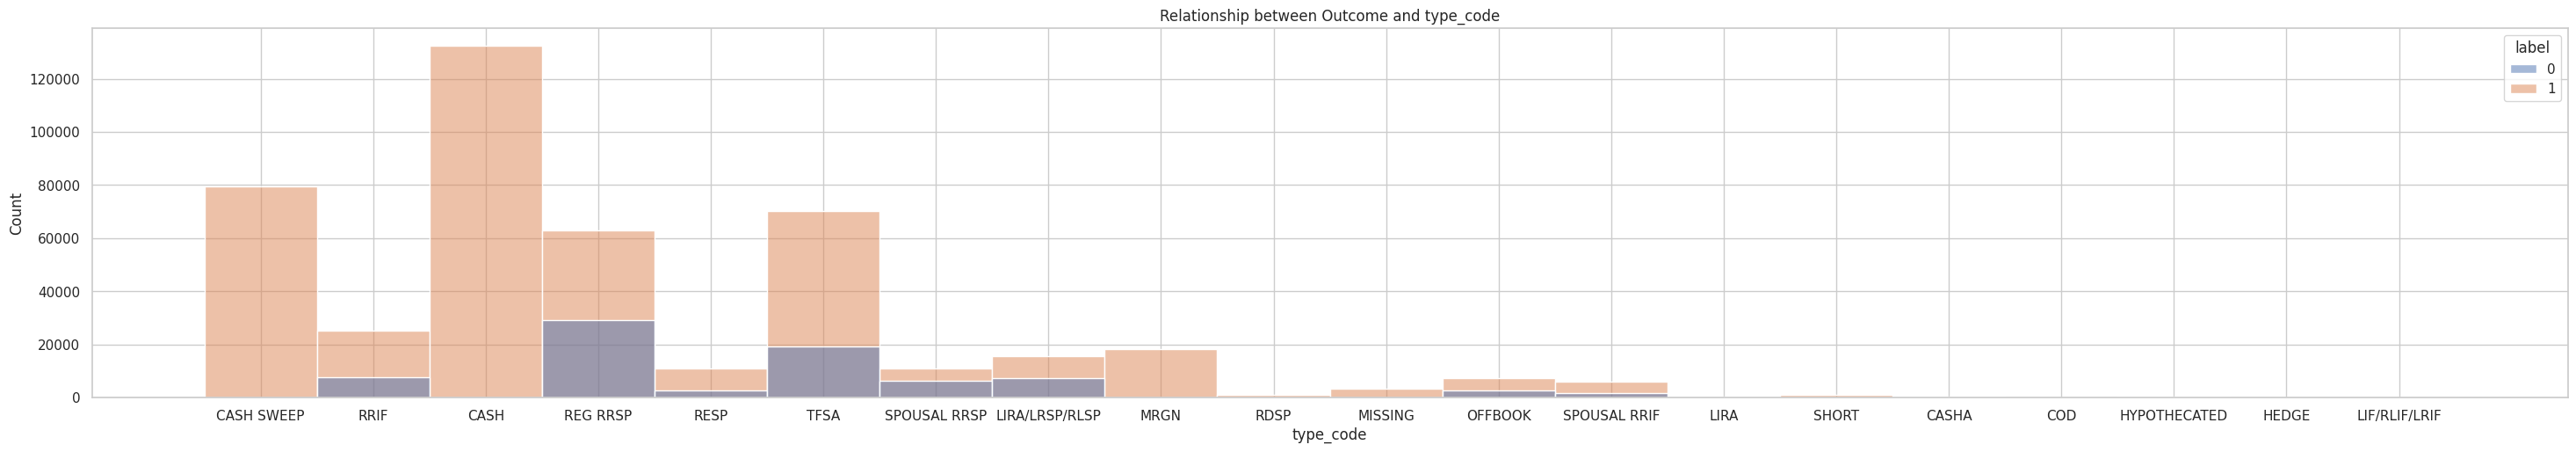

In [116]:
# @title
plt.figure(figsize=(80, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x=df_copy['type_code'], hue=df_copy_encoded['label'], bins=30, kde=False, color='blue').set(title='Relationship between Outcome and type_code')

Recall that label of 1 is Churned, 0 for Not Churned. Looks like most clients with type_code of CASH SWEEP, CASH, and MRGN churned from the service

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


[Text(0.5, 1.0, 'Relationship between Outcome and number of beneficiaries')]

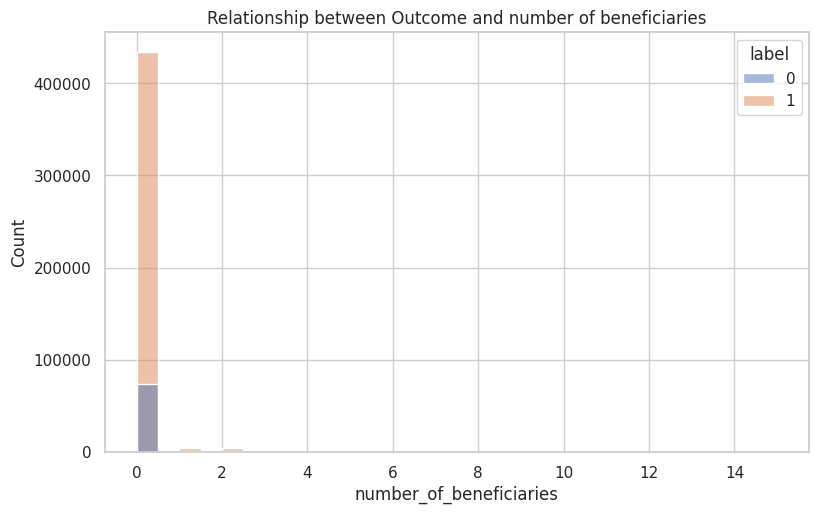

In [117]:
# @title
plt.figure(figsize=(20, 12))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(2, 2, 1)
sns.histplot(x=df_copy['number_of_beneficiaries'], hue=df_copy_encoded['label'], bins=30, kde=False, color='blue').set(title='Relationship between Outcome and number of beneficiaries')

Most of the clients doesnt' have any beneficiaries, and we can see that most clients churned.

In [118]:
df_copy_train, df_ = train_test_split(df_copy_encoded, test_size=0.40, random_state=1)
df_copy_cv, df_copy_test = train_test_split(df_, test_size=0.50, random_state=1)

del df_

X_train = df_copy_train.drop('label', axis=1)
y_train = df_copy_train['label']

X_cv = df_copy_cv.drop('label', axis=1)
y_cv = df_copy_cv['label']

X_test = df_copy_test.drop('label', axis=1)
y_test = df_copy_test['label']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (312787, 311)
y_train shape: (312787,)
X_cv shape: (104263, 311)
y_cv shape: (104263,)
X_test shape: (104263, 311)
y_test shape: (104263,)


In [119]:
X_train = np.array(X_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

X_cv = np.array(X_cv).astype(np.float32)
y_cv = np.array(y_cv).astype(np.float32)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

In [120]:
pd.set_option('display.max_colwidth', None)

## Approach to the Churn problem
We came up with the idea that customers, who may not know each other, will somehow relate to each other based on psychology, for example, and that could determine the churn/no churn behavior of each client. Thus, we treat the customer data as a network, and we will propose a probabilistic approach (which is different from the mainstream approaches towards churning problem) that can predict which groups of customers are most prone to churn before any member in each group has churned.


* in this approach, we will develop a Stochastic Block Model (SBM) to identify potential churners in a network
* We will proceed with a group (cluster) approach rather than individual (customer, node) approach

### Advantages of network-based approach

* One advantage of network-based approach compared to traditional approaches (logistic regression, etc.) is that we can identify influential customers in a churn network. If they churned, that would affect others to churn as well. Traditional approaches only tell you which customers have churned, but not how influential the customers are.
* Furthermore, even though a traditional approach can pinpoint the potential customers that churned, the forecast horizon this approach gives is usually short. The traditional approach identifies customers that have already expressed dissatisfaction with the service. Therefore, the retention prospects are lower, while the cost to retain them is higher.
* Also, even when we try to combine a longer time horizon with the traditional approach, there's some other drawbacks:
    * We assume that a churning customer might just exhibit dissatisfaction with the current credit service prior to switching to competitors. While this may be true in some cases, there're other scenarios in which these assumptions are not valid:
        * Some customers still find the current credit service totally okay, but they have found a better service with another credit company. Thus, they churn immediately.
    * Other cases we want to consider:
        * A churning customer influences other customers to churn.
    

### Group-First approach
Instead of solving this problem based on each customer (node), we approach each group (community) of customers. The idea is that the members of more dense groups tend to have more similar credit usage behavior, thus they have a strong bond to remain together with the same credit company. Therefore, we can save costs on retaining those customers. On the other hand, small groups have dominant leaders (influential customers) that affect the overall group's decision to churn


### Challenge of the approach & tasks
We have to correctly pinpoint groups that are at a high churn risk, even though none of the members have churned. This is the goal that we need to tackle.

Tasks:
* Assign weights to edges
* Quantify the relatedness between any 2 customers

## Stochastic Block Model (SBM)
We apply an SBM together with the Group-First approach to tackle this churning problem. A probabilistic model can capture the influence of social interactions on customer behavior. Meanwhile, traditional models like logistic regression typically treat each customer as individuals. These models ignore how connections between customers can affect churn.

In [121]:
import networkx as nx
from scipy.optimize import minimize

In [122]:
# don't remove the missing data after clustering df_copy
# as this resulted in a loss of 7 clusters out of 10 clusters (only cluster 8, 0, 3 left)
# so try to impute missing data with something else

After data processing, we have 3 clusters (cluster 8, 0, 3) that represent each community of customers, we can base that for the initial number of blocks. Let's print the number of customers (potential nodes) in each cluster (community/block)

In [123]:
# visualize each cluster of customers
from mpl_toolkits.mplot3d import Axes3D

In [124]:
# # visualize each cluster of customers
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# # scatter plot
# pca_1 = df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 8]
# pca_2 = df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 0]
# pca_3 = df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 3]
# scatter = ax.scatter(pca_1, pca_2, pca_3, c=df_copy_with_clusters['Clusters'], cmap='Set1', s=100)
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)

# # label
# ax.set_xlabel('PCA1')
# ax.set_ylabel('PCA2')
# ax.set_zlabel('PCA3')
# ax.set_title('Visualization of Clusters')

# plt.show()

In [125]:
# number of customers for Cluster 8
print(f"Number of Customers in Cluster 8: {len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 8])}")
print(f"Number of Customers in Cluster 0: {len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 0])}")
print(f"Number of Customers in Cluster 3: {len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 3])}")

Number of Customers in Cluster 8: 125130
Number of Customers in Cluster 0: 376523
Number of Customers in Cluster 3: 19660


In [126]:
# cluster 8 data
df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 8]

type_code is_registered currency_code is_active  class_id debit_code  \
0       CASH SWEEP             f           CAD         t       3.0          0   
20            CASH             f           CAD         t       3.0          T   
31      CASH SWEEP             f           CAD         t       3.0          A   
39      CASH SWEEP             f           CAD         t       3.0          0   
40            MRGN             f           CAD         t       3.0          A   
...            ...           ...           ...       ...       ...        ...   
521293  CASH SWEEP             f           CAD         t       3.0          A   
521294  CASH SWEEP             f           CAD         t       3.0          A   
521302        MRGN             f           CAD         t       7.0          A   
521307  CASH SWEEP             f           CAD         t       3.0          0   
521312  CASH SWEEP             f           CAD         t       3.0          A   

       last_trade_date  contract_type inception_date net_of_fees  \
0           2018-07-06           18.0     2017-08-18           f   
20          2018-07-06           18.0     2019-09-26           f   
31          2018-07-06           18.0     2017-08-18           f   
39          2018-07-06           18.0     2017-08-18           f   
40          2019-09-03           18.0     2017-07-21           f   
...                ...            ...            ...         ...   
521293      2018-07-06           18.0     2017-08-18           f   
521294      2018-07-06           18.0     2017-08-18           f   
521302      2016-04-29           18.0     2013-01-21           f   
521307      2018-07-06            0.0     2018-03-07           f   
521312      2018-07-06           18.0     2017-08-18           f   

       fee_paid_separately custody_fee_withdrawal is_fee_exempt branch  \
0                        f                      f             f   IAVM   
20                       f                      f             f   IAVM   
31                       f                      f             f   IAVM   
39                       f                      f             f   IAVM   
40                       f                      f             f   IAVM   
...                    ...                    ...           ...    ...   
521293                   f                      f             f   IAVM   
521294                   f                      f             f   IAVM   
521302                   f                      f             f   IAVM   
521307                   f                      f             f   IAVM   
521312                   f                      f             f   IAVM   

        credit_limit_type retail_plan is_spousal is_arp_locked  \
0                     0.0          RS          f             f   
20                    0.0          RS          f             f   
31                    0.0          RS          f             f   
39                    0.0          RS          f             f   
40                    0.0          RS          f             f   
...                   ...         ...        ...           ...   
521293                0.0          RS          f             f   
521294                0.0          RS          f             f   
521302                0.0          RS          f             f   
521307                0.0          RS          f             f   
521312                0.0          RS          f             f   

       arp_pension_origin language_code  dividend_confirm_code sss_location  \
0                      ON             E                    0.0            T   
20                     ON             E                    0.0            T   
31                     ON             E                    0.0            T   
39                     ON             E                    0.0            T   
40                     ON             E                    0.0            T   
...                   ...           ...                    ... 

In [127]:
# debit codes in the cluster 3
df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 3]['debit_code'].unique()

array(['A', 'T', '0', 'C', 'R', 'P', 'N', 'M', '5', 'F', 'L'],
      dtype=object)

In [128]:
# understand the debit code value extracted from Field Values in debit_code
data_info_copy.loc[data_info_copy['Columns'] == 'debit_code', 'Field Values']

7    0  None\n 1  Normal\n [2-9] or [A-Z] (except I, O, Q)  Special
Name: Field Values, dtype: object

In [129]:
print("7    0  None\n 1  Normal\n [2-9] or [A-Z] (except I, O, Q)  Special")

7    0  None
 1  Normal
 [2-9] or [A-Z] (except I, O, Q)  Special


In [130]:
data_info_copy.loc[data_info_copy['Columns'] == 'type_code', 'Field Values']

0    CSH - Cash/RSP (note: Registered accounts are account type CSH; plan type is determined by PLAN IND)
Name: Field Values, dtype: object

Since we know the number of customers per cluster, we can initialize a list of block sizes

In [131]:
cluster_8_customers = len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 8])
cluster_0_customers = len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 0])
cluster_3_customers = len(df_copy_with_clusters[df_copy_with_clusters['Clusters'] == 3])

block_sizes = [cluster_8_customers, cluster_0_customers, cluster_3_customers]

Next, we have to compute the cosine similarity among features so we can construct an adjacency matrix later on.

In [132]:
from sklearn.metrics.pairwise import cosine_similarity

In [133]:
df_copy_no_label_no_clusters = df_copy_with_clusters[[col for col in df_copy_with_clusters if col not in ['label', 'Clusters']]]

# encode
df_copy_no_label_no_clusters_encoded = binary_encoder.fit_transform(df_copy_no_label_no_clusters)

/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/opt/conda/lib/python3.10/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change 

In [134]:
df_copy_no_label_no_clusters_encoded

type_code_0  type_code_1  type_code_2  type_code_3  type_code_4  \
0                 0            0            0            0            1   
1                 0            0            0            1            0   
2                 0            0            0            1            1   
3                 0            0            1            0            0   
4                 0            0            0            1            1   
...             ...          ...          ...          ...          ...   
521308            0            0            1            0            0   
521309            0            1            0            0            0   
521310            0            0            1            0            0   
521311            0            0            0            1            0   
521312            0            0            0            0            1   

        is_registered_0  is_registered_1  currency_code_0  currency_code_1  \
0                     0                1                0                1   
1                     1                0                0                1   
2                     0                1                0                1   
3                     1                0                0                1   
4                     0                1                0                1   
...                 ...              ...              ...              ...   
521308                1                0                0                1   
521309                1                0                0                1   
521310                1                0                0                1   
521311                1                0                0                1   
521312                0                1                0                1   

        is_active_0  is_active_1  class_id_0  class_id_1  class_id_2  \
0                 0            1           0           0           0   
1                 0            1           0           0           0   
2                 0            1           0           0           0   
3                 0            1           0           0           0   
4                 0            1           0           0           0   
...             ...          ...         ...         ...         ...   
521308            0            1           0           0           0   
521309            0            1           0           0           0   
521310            1            0           0           0           0   
521311            0            1           0           0           0   
521312            0            1           0           0           0   

        class_id_3  class_id_4  class_id_5  debit_code_0  debit_code_1  \
0                0           0           1             0             0   
1                0           1           0             0             0   
2                0           0           1             0             0   
3                0           1           0             0             0   
4                0           0           1             0             0   
...            ...         ...         ...           ...           ...   
521308           0           1           0             0             0   
521309           0           1           0             0             0   
521310           0           1           0             0             0   
521311           0           1           0             0             0   
521312           0           0           1             0             0   

        debit_code_2  debit_code_3  debit_code_4  last_trade_date_0  \
0                  0             0             1                  0   
1                  0             1             0                  0   
2                  0             1             1                  0   
3                  0             1             0                  0   
4                  0             1             1             

### Dimensionality reduction for cosine similarity computation

As there are 328 features, it would be infeasible for any models or computing system to process or compute cosine similarity from this dataset, which will be the next step towards constructing an adjacency matrix.

**Explanation on why cosine similarity for adjacency matrix**: we want to measure the similarity between any 2 customers based on the given features, and we will set a threshold on the cosine similarity value to decide if there should be an edge (link) between the 2 customers.

However, as the number of features is huge, it might be infeasible for any models or computing system to calculate the cosine similarity between any 2 customers out of 521313 customers. The resulting cosine similarity matrix will have the shape of $(521313^2, 521313^2)$ and the cosine similarity computation is run from the background given 328 different features (impossible with the given CPU resource). 

Therefore, we need to perform PCA one more time. This time is for actual dimensionality reduction, compared to last time (when PCA was used to handle missing data).

In [135]:
# covariance matrix and eigenvalues for each column of the dataset
df_cov_mat = np.cov(df_copy_no_label_no_clusters_encoded.T)
df_eigen_vals, df_eigen_vecs = np.linalg.eig(df_cov_mat)

print(f"Eigenvalues: \n {df_eigen_vals}")
print(f"Eigenvalues shape: {df_eigen_vals.shape}")

Eigenvalues: 
 [ 4.46964124e+00+0.00000000e+00j  2.01876039e+00+0.00000000e+00j
  1.04993783e+00+0.00000000e+00j  9.01717808e-01+0.00000000e+00j
  8.36314748e-01+0.00000000e+00j  6.36375846e-01+0.00000000e+00j
  5.28129533e-01+0.00000000e+00j  4.81304734e-01+0.00000000e+00j
  4.21030820e-01+0.00000000e+00j  3.99535774e-01+0.00000000e+00j
  3.97067861e-01+0.00000000e+00j  3.40063734e-01+0.00000000e+00j
  3.25462267e-01+0.00000000e+00j  3.05707734e-01+0.00000000e+00j
  2.93364590e-01+0.00000000e+00j  2.82738034e-01+0.00000000e+00j
  2.64635862e-01+0.00000000e+00j  2.52743785e-01+0.00000000e+00j
  2.40708490e-01+0.00000000e+00j  2.36266112e-01+0.00000000e+00j
  2.32284581e-01+0.00000000e+00j  2.21168167e-01+0.00000000e+00j
  2.16478384e-01+0.00000000e+00j  2.18216791e-01+0.00000000e+00j
  2.08194667e-01+0.00000000e+00j  2.00003646e-01+0.00000000e+00j
  1.98242004e-01+0.00000000e+00j  1.96676384e-01+0.00000000e+00j
  1.95113526e-01+0.00000000e+00j  1.90611435e-01+0.00000000e+00j
  1.879627

/opt/conda/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


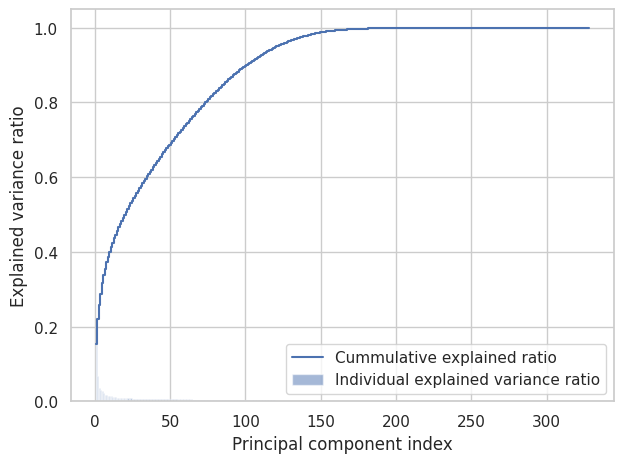

In [136]:
explain_variance(df_eigen_vals)

50 PCA axes explain about 70% of the variance of the dataset. Thus, we would pick 50 as the number of PCA axes.

In [137]:
# import library for the nearest neighbor algorithm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [138]:
# reduce the dimension of df_copy_no_label_no_clusters_encoded
clean_df_pca = PCA(n_components=50)
reduced_df = clean_df_pca.fit_transform(df_copy_no_label_no_clusters_encoded)

After performing PCA on `df_copy_no_label_no_clusters_encoded` (the clean dataset), we checked for its new dimension. As expected, the number of features is now reduced to 50.

In [139]:
# check for the reduced clean dataset's shape
reduced_df.shape

(521313, 50)

In [140]:
# reduced_df in dataframe
reduced_df_copy = pd.DataFrame(reduced_df)

In [141]:
reduced_df_copy

0         1         2         3         4         5         6   \
0       3.926844  1.068795  0.079339 -0.152582 -0.821786  0.453186  0.143102   
1      -0.972382  0.330890 -0.109479 -1.295054 -1.472033 -0.287527  0.103132   
2       1.429770 -1.677934 -0.628921 -0.873785 -1.053023 -0.251166 -0.828703   
3      -0.739121  0.984292 -0.161051 -1.752890 -0.672029 -0.314687 -0.680266   
4       1.250280 -1.591681 -0.212701 -1.408988 -0.568149 -0.620248  0.247217   
...          ...       ...       ...       ...       ...       ...       ...   
521308 -1.582508  0.487892 -1.019575  1.805122 -0.935448 -0.317590 -0.329941   
521309 -1.568165  0.180062  0.345196  1.047959 -1.783413  0.316767 -0.471214   
521310 -1.377518  1.231179  2.298050  0.440597 -0.415916 -0.398885 -1.902630   
521311 -1.461329 -0.224186 -2.016422  0.006761  0.340533  1.154574 -0.317599   
521312  3.800015  1.322404  0.449637  0.172453 -0.342161  0.294548  0.144773   

              7         8         9         10        11        12        13  \
0       0.038318  0.230034 -0.264338 -0.094939 -0.107246  0.123204 -0.164938   
1      -0.584028 -0.977153  0.302563  1.259633 -1.247449 -0.394016 -0.037247   
2      -0.493570  0.188868 -0.024678 -0.120027 -0.542910  0.090587 -0.913828   
3       0.243984 -0.141385  1.011933  1.045349  0.249217 -0.004548 -0.037121   
4      -0.611729  0.677926  0.202685  0.848114 -0.030814 -0.009863 -0.791855   
...          ...       ...       ...       ...       ...       ...       ...   
521308 -0.310988  1.324071  0.526312  0.152872  0.210355  0.320723 -0.368917   
521309  0.064253  0.916877  0.190100  0.548917 -0.305879  1.060376  0.896222   
521310 -0.176486  0.422839  1.410917 -0.071622  0.088986  0.234737 -0.083738   
521311 -0.933452  0.371539  0.101512 -0.838107 -0.542151 -0.057168  0.959769   
521312 -0.177155  0.748507  0.523445 -0.481843  0.250088  0.231897 -0.213751   

              14        15        16        17        18        19        20  \
0      -0.022955  0.220835  0.202564 -0.085078 -0.297805  0.224181 -0.025422   
1       0.109151  0.346420  0.446453  0.125241 -0.079836  0.647389 -0.084935   
2       0.197947 -0.010837 -0.117765  0.027301 -0.498090  0.957721 -0.070946   
3       0.244376  0.869437 -0.072633  0.313395 -0.393372  0.091655  0.151154   
4       0.297435  0.555237  0.218031  0.064675 -0.452343  0.248435  0.263318   
...          ...       ...       ...       ...       ...       ...       ...   
521308 -0.282517  0.789810 -0.545812 -0.648641 -0.098509  0.353235  0.422861   
521309  0.088565 -1.141786  0.446366 -0.724232  0.089544 -1.480811  0.007222   
521310  0.189808 -0.127535  0.484299 -0.148372  0.069410  0.708618  0.084150   
521311 -0.059050  0.539010 -0.319402 -1.011223 -1.300928  0.158658 -0.646355   
521312 -0.650500  0.485044  0.061873 -0.166983 -0.428773 -0.275230  0.015249   

              21        22        23        24        25        26        27  \
0      -0.332771  0.113520  0.095226  0.280138  0.159182 -0.073595 -0.082605   
1       0.083553 -0.419452 -0.199828  0.144087 -0.261578 -0.160559 -0.316197   
2       0.155618 -0.234224  0.240972  0.271556  0.554966 -0.261428 -0.583030   
3      -0.555950 -0.340605  0.351959 -0.066086 -0.148901  0.258139 -0.390848   
4      -0.307464 -0.328735  0.546522  0.530781 -0.202720  0.382760 -0.570456   
...          ...       ...       ...       ...       ...       ...       ...   
521308 -0.830478 -0.298140  0.758763 -0.335695  0.774487  0.142023  0.043168   
521309  1.012923 -0.665491 -1.267160 -0.332071  0.586555  0.859505  0.308534   
521310 -0.682295 -0.051124  0.024720  0.253408 -0.218576 -0.193082 -0.519464   
521311  0.833010  0.304684 -0.567890  0.492891 -0.188688  0.127025 -0.057917   
521312 -0.144810  0.219720  0.273372  0.670983 -0.771593  0.010577  0.189555   

              28        29        30        31        32        33        34  \
0       0.827746 -0.192317  0.023280  0.047480  0.053763 -0.217263 -0.015108   
1      -0.

### Handling available memory and choose the optimal number of neighbors
As the following process may take up a lot of available GPU resource, we have to manually calculate the memory this process may consume to prevent restarting the kernel (then we have to restart running each cell)

In [142]:
import psutil
n_customers = reduced_df.shape[0]

# start with a small number of neighbors and also the maximum number of neighbors
init_neighbors = 5
max_neighbors = 100
step = 5

def check_memory():
    return psutil.virtual_memory().available / (1024 ** 2)  # Convert bytes to MB


optimal_neighbors = init_neighbors

# check for the most optimal number of neighbors
for k in range(init_neighbors, max_neighbors + 1, step):
    memory_usage = n_customers * k * 12 / (1024 ** 2)  # Convert bytes to MB
    available_memory = check_memory()
    print(f"Memory usage for {k} neighbors: {memory_usage}")
    
    if memory_usage < available_memory:
        optimal_neighbors = k
    else:
        break

print("\n")
print(f"Available memory for {k} neighbors: {available_memory}\n")
print(f"Optimal number of neighbors: {optimal_neighbors}")

Memory usage for 5 neighbors: 29.829769134521484
Memory usage for 10 neighbors: 59.65953826904297
Memory usage for 15 neighbors: 89.48930740356445
Memory usage for 20 neighbors: 119.31907653808594
Memory usage for 25 neighbors: 149.14884567260742
Memory usage for 30 neighbors: 178.9786148071289
Memory usage for 35 neighbors: 208.8083839416504
Memory usage for 40 neighbors: 238.63815307617188
Memory usage for 45 neighbors: 268.46792221069336
Memory usage for 50 neighbors: 298.29769134521484
Memory usage for 55 neighbors: 328.1274604797363
Memory usage for 60 neighbors: 357.9572296142578
Memory usage for 65 neighbors: 387.7869987487793
Memory usage for 70 neighbors: 417.6167678833008
Memory usage for 75 neighbors: 447.44653701782227
Memory usage for 80 neighbors: 477.27630615234375
Memory usage for 85 neighbors: 507.10607528686523
Memory usage for 90 neighbors: 536.9358444213867
Memory usage for 95 neighbors: 566.7656135559082
Memory usage for 100 neighbors: 596.5953826904297


Available

Even with 100 nearest neighbors for each data point (customer), the memory usage is not comparable to the available memory that we are currently having. Therefore, we don't really have to worry about the memory issue. With more neighbors, the similarity calculations may capture more nuanced relationships between customers. This can improve the quality of the similarity matrix and lead to better clustering (blocks) and recommendations later on. We will choose 100 as the number of neighbors for the ANN algorithm.

### Cosine similarity computation for constructing an adjacency matrix
The next step towards constructing a network among customers is to calculate the cosine simlarity between pairs of customers. As mentioned, there are 521313 customers, which makes this computation infeasible for most systems. We will propose an approach that will approximate the nearest neighbors corresponding to each customer, which will avoid having to compute the full similarity matrix.

In [143]:
from scipy.sparse import csr_matrix

In [144]:
nbrs = NearestNeighbors(n_neighbors=100, algorithm='auto', metric='cosine').fit(reduced_df)
distances, indices = nbrs.kneighbors(reduced_df)

In [145]:
distances.shape

(521313, 100)

In [146]:
# Each row corresponds to a customer, and each column corresponds to the distance from a neighbor to that customer (row)
distances_df = pd.DataFrame(distances)
distances_df

0             1             2             3             4   \
0       0.000000e+00  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16   
1       0.000000e+00  1.074420e-01  1.124180e-01  1.176594e-01  1.223301e-01   
2       0.000000e+00  1.110223e-16  3.569814e-02  1.186344e-01  1.609713e-01   
3       0.000000e+00  1.753295e-01  1.772992e-01  1.860597e-01  1.958708e-01   
4       0.000000e+00  1.530218e-01  1.960008e-01  1.998285e-01  2.181062e-01   
...              ...           ...           ...           ...           ...   
521308  0.000000e+00  9.136733e-02  1.245741e-01  2.220605e-01  2.271787e-01   
521309  0.000000e+00  6.979472e-02  1.194224e-01  1.626282e-01  1.658701e-01   
521310  2.220446e-16  1.204863e-01  1.211237e-01  1.247295e-01  1.299132e-01   
521311  3.330669e-16  1.701200e-01  2.479369e-01  2.563412e-01  2.576729e-01   
521312  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  5             6             7             8             9   \
0       1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16   
1       1.244435e-01  1.245553e-01  1.446755e-01  1.462036e-01  1.543249e-01   
2       1.615322e-01  1.745282e-01  1.745282e-01  1.745282e-01  1.745282e-01   
3       2.065539e-01  2.072540e-01  2.086203e-01  2.098352e-01  2.123962e-01   
4       2.263011e-01  2.278390e-01  2.289256e-01  2.322154e-01  2.338308e-01   
...              ...           ...           ...           ...           ...   
521308  2.329518e-01  2.365798e-01  2.449744e-01  2.491798e-01  2.596467e-01   
521309  1.685410e-01  1.825449e-01  1.933289e-01  2.098638e-01  2.104630e-01   
521310  1.370654e-01  1.394056e-01  1.398434e-01  1.488473e-01  1.489397e-01   
521311  2.629265e-01  2.644417e-01  2.667518e-01  2.731957e-01  2.742213e-01   
521312  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  10            11            12            13            14  \
0       1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16   
1       1.548131e-01  1.548869e-01  1.549705e-01  1.554347e-01  1.554968e-01   
2       1.755555e-01  1.758067e-01  1.759386e-01  1.759386e-01  1.762981e-01   
3       2.243790e-01  2.286072e-01  2.328665e-01  2.335270e-01  2.357544e-01   
4       2.371681e-01  2.410067e-01  2.432258e-01  2.454853e-01  2.459588e-01   
...              ...           ...           ...           ...           ...   
521308  2.603256e-01  2.613674e-01  2.640805e-01  2.663922e-01  2.677763e-01   
521309  2.173852e-01  2.342115e-01  2.351799e-01  2.420153e-01  2.447907e-01   
521310  1.521656e-01  1.573689e-01  1.615089e-01  1.647098e-01  1.654793e-01   
521311  2.809513e-01  2.840926e-01  2.845182e-01  2.851163e-01  2.879508e-01   
521312  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  15            16            17            18            19  \
0       1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16   
1       1.595765e-01  1.600183e-01  1.625681e-01  1.648327e-01  1.656151e-01   
2       1.783498e-01  1.830810e-01  1.830810e-01  1.830810e-01  1.830810e-01   
3       2.368635e-01  2.403827e-01  2.414306e-01  2.421001e-01  2.431720e-01   
4       2.473758e-01  2.479272e-01  2.520698e-01  2.536935e-01  2.541284e-01   
...              ...           ...           ...           ...           ...   
521308  2.712866e-01  2.725572e-01  2.773142e-01  2.815240e-01  2.840201e-01   
521309  2.490895e-01  2.507350e-01  2.532288e-01  2.534830e-01  2.539826e-01   
521310  1.679686e-01  1.679757e-01  1.682807e-01  1.688795e-01  1.703031e-01   
521311  2.895798e-01  2.924669e-01  2.931887e-01  2.948227e-01  3.019457e-01   
521312  1.110223e-16  3.203226e-03  3.203226e-03  8.410357e-03  1.007198e-02   

                  20            21            22            23            24  \
0       1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16  1.110223e-16   
1       1.6833

In [147]:
# each entry in indices corresponds to the row indices of the nearest neighbors for each customer
indices_df = pd.DataFrame(indices)
indices_df

0       1       2       3       4       5       6       7   \
0            0  310372  497626    6764  478213  348593  487881  385374   
1            1  275218  452330  375322   69108   63556  148111  288592   
2       488850       2  221950  102421  322363  397170  477438   92707   
3            3  340571   89249  206772   15403  396656   39909  256178   
4            4  249479  157280  482152  429570  253359  283315  469805   
...        ...     ...     ...     ...     ...     ...     ...     ...   
521308  521308  209625  488540   44511  186896  303709  449138  138005   
521309  521309  467125  293586  498076  307240  412304  519834  468028   
521310  521310  477037  139112  416481  224844   50924  410459  335791   
521311  521311  444900  312867  385431  246835   10242  345355  220459   
521312  515391  404664   88900  148444   69191   26201  242757  389775   

            8       9       10      11      12      13      14      15  \
0       513390  472376  479726  415862  107425   98959  283882  416735   
1       508512  261064  465190  367150    4645  279676  442277  138503   
2       337858  411678  492846  406710  383006  155547   90446  322301   
3       486421  380104  108511  184732  259978  311178  252409  109129   
4        57050  103619  189207   87616   83598  167134  301953  333534   
...        ...     ...     ...     ...     ...     ...     ...     ...   
521308  516030  366474   99550  381859  261852  162784  479769  139752   
521309   31517   89430  189933   55203  266214  140000  101305  150540   
521310  233892  218569   61298  179077   87308  309408  513906  464062   
521311    3629  148339  344088  249261   65513  198161  231862  283443   
521312  362947   33937  288952  130272  416020  269832    6081  521312   

            16      17      18      19      20      21      22      23  \
0       338128  274402    3218  432984  105558  509217   81380   39415   
1       433507   56456  426641   12609  348443   73997  198668  184839   
2       457936  288835  250352  401455   55930  194723  121838  129559   
3       240072  184437  302812  192314  347104  273697  333880  296322   
4        75514  391669   14754  451391  214171  300558  379900   39350   
...        ...     ...     ...     ...     ...     ...     ...     ...   
521308  291280  398365  182171  189441   11152  175845   51066  223723   
521309  195752  433249  514235   43735  228376  460823   20812  100737   
521310  418707  223252  270091  448438  415743  281400  467666  200528   
521311  500157   50253    2610  385372  327824  276822  354888  343535   
521312   11586  283446   24832  232640  344823  204036  460414  143917   

            24      25      26      27      28      29      30      31  \
0       292806  443732   52004  303715  319206   69188  138970  250425   
1       511190  143748  127637  282194  322383  385598  250600  263968   
2       317274  406047  332405  103648   38233  360587   86914  460686   
3       390762  193098   68943  408652   44254  142343  396665  215835   
4       333490  471895  115430  342188  139220  418744  454008  478448   
...        ...     ...     ...     ...     ...     ...     ...     ...   
521308  164050  339810  203403  291911   29512  423961  333081  494829   
521309  383069  510142  492325  514260  470497    3692  303027  233642   
521310  267734  256206    7685    2453  191316  147761   66482  271928   
521311  192814   36121  194208  138861  496242  107106  201697  192571   
521312  163471  133097  480356  380163  425087   91602  258651  470748   

            32      33      34      35      36      37      38      39  \
0       253668  480094  362893  467393  269872  475072   63312  271809   
1        39789  368763  178644  410949  120303  149343  322640  365736   
2       181075  517779  196192  201695  416251  359764  315298  253326   
3       391151  151054  233245   82284  129202  321779  268239  200767   
4       443672  198067  154388  160615  517820  105720   55058  374887   
...        .

In [148]:
# 100 most similar customers to customer 0
indices_df.head(1).values

array([[     0, 310372, 497626,   6764, 478213, 348593, 487881, 385374,
        513390, 472376, 479726, 415862, 107425,  98959, 283882, 416735,
        338128, 274402,   3218, 432984, 105558, 509217,  81380,  39415,
        292806, 443732,  52004, 303715, 319206,  69188, 138970, 250425,
        253668, 480094, 362893, 467393, 269872, 475072,  63312, 271809,
         51551, 244751, 107999, 498911, 448343, 188531, 319656, 470182,
         31665,  49599, 136160, 202528, 301913, 168625, 382655, 312562,
        353800, 377421, 197242,  17996, 502319,  31149, 299461, 385234,
        357228, 304356, 145944, 250175,  20555, 441005, 441239,  82862,
        396313, 244916, 325086,  90152, 214220, 452980, 255418, 275403,
        136626, 159585, 456856, 315355, 388612, 400947, 135064, 317642,
        422780, 185602, 355276, 355504, 135236, 486645, 424843, 289635,
        262347, 298159, 124002, 452565]])

### Sparse similarity matrix
The idea of constructing a sparse similarity matrix is to efficiently store similarity calculations. When calculating pairwise similarities, most values will be equal to 0 (as the data set is in a high dimensionality). Sparse matrices store only significant similarities.

In [149]:
# construct the sparse similarity matrix
customers_indices = []
neighbors_indices = []
cos_sim_vals = []

for i, neighbors in enumerate(indices):
    for j, neighbor in enumerate(neighbors):
        customers_indices.append(i)
        neighbors_indices.append(j)
        cos_sim_vals.append(1 - distances[i][j])

sparse_similarity_matrix = csr_matrix((cos_sim_vals, (customers_indices, neighbors_indices)), shape=(len(reduced_df), len(reduced_df)))

In [150]:
# sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_similarity_matrix)

In [151]:
# calculate cosine similarity among encoded features
encoded_features = df_copy_no_label_no_clusters_encoded[[col for col in df_copy_no_label_no_clusters_encoded]].values

In [152]:
encoded_features[0]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [153]:
# shape of encoded_features
encoded_features.shape

(521313, 328)

### Constructing a sparse cosine similarity matrix without ANN

Since the encoded dataset is very huge, and our approach is to first create an adjacency matrix for each 2 customers out of 521313 customers, it would require $521313^2$ entries, (521313, 521313) matrix shape for the adjacency matrix. This is impractical for most machines. Therefore, we'd split the dataset into smaller encoded datasets. Let's random split into smaller customer subsets.

In [154]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, lil_matrix

In [155]:
def compute_sparse_cosine_sim_batch(data, batch_size=100, threshold=0.1):
    n = data.shape[0]
    sparse_sim_matrix = lil_matrix((n, n))
    
    # after performing cosine similarity on batch, jump by the batch size to the next batch
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch = data[i:end_i]
        batch_sim = cosine_similarity(batch, data)
        
        # store only significant similarities determined by threshold for computational purposes
        batch_sim[batch_sim < threshold] = 0
        sparse_sim_matrix[i:end_i] = csr_matrix(batch_sim)
        
    return sparse_sim_matrix.tocsr()

In [156]:
# cosine similarity for the first batch of first 100 customers

batch_size = 100
threshold = 0.1

sample_sparse_sim_matrix = compute_sparse_cosine_sim_batch(df_copy_no_label_no_clusters_encoded[:100], batch_size, threshold)

sample_adj_df_sparse = pd.DataFrame.sparse.from_spmatrix(sample_sparse_sim_matrix)

sample_adj_df_sparse

0         1         2         3         4         5         6   \
0        1.0  0.758242  0.872785  0.774373  0.849111  0.695353  0.786214   
1   0.758242       1.0  0.851498  0.881924  0.817662  0.821781  0.859594   
2   0.872785  0.851498       1.0  0.812544  0.923965  0.765346  0.863044   
3   0.774373  0.881924  0.812544       1.0  0.831042  0.835229  0.892601   
4   0.849111  0.817662  0.923965  0.831042       1.0  0.763829      0.83   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.682282  0.807207  0.753921  0.790031   0.76086  0.764693  0.788361   
96   0.67966   0.75962  0.687347  0.782586  0.715097  0.747447  0.743701   
97   0.78604   0.79599  0.867352  0.779052  0.854242  0.772691  0.797293   
98  0.689655   0.83958  0.755114  0.782586   0.76277  0.737865  0.800909   
99  0.792429  0.792429  0.892253  0.765872  0.840971  0.740744  0.793725   

          7         8         9         10        11        12        13  \
0   0.793525  0.740108  0.857731  0.819566  0.753456  0.754765  0.730158   
1   0.880487   0.85318  0.836553   0.83021  0.855275  0.838628  0.876189   
2   0.821235  0.816416  0.923089  0.876289  0.848125   0.82243  0.808246   
3   0.883029  0.845086  0.818752  0.822961  0.847041  0.810523  0.837127   
4   0.808822  0.813882  0.888934  0.873198   0.81588      0.81   0.79603   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.798481  0.835974  0.722284  0.735305  0.810242  0.797528  0.802691   
96  0.761295  0.776006  0.703094  0.697028  0.740868  0.715097  0.768472   
97  0.777542  0.800424  0.824563  0.809528  0.783618   0.77831   0.80278   
98  0.790956  0.794705  0.780146  0.755114  0.805694  0.810443  0.777959   
99  0.774064  0.787577  0.859054    0.8155  0.807645  0.793725  0.799189   

          14        15        16        17        18        19        20  \
0   0.779639  0.712893  0.723317  0.785008  0.699256   0.76435  0.928343   
1   0.842853  0.843423  0.859594  0.815996     0.831  0.826325  0.771881   
2   0.836778   0.77802  0.781817  0.830374  0.795073  0.830374  0.858761   
3   0.886786   0.84513  0.861822  0.849178  0.813318  0.849178  0.786083   
4   0.814081  0.794996      0.77   0.80797  0.754054  0.798117  0.845782   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.783119  0.825356  0.806695  0.840022  0.833034   0.79486  0.711476   
96   0.75703  0.812794  0.743701   0.75158  0.783485  0.723395  0.683086   
97  0.782231  0.763668  0.768818  0.813653  0.779948  0.766891  0.812225   
98  0.747447  0.767131  0.829512  0.807948  0.774268  0.789159  0.721035   
99  0.778731  0.769302  0.765378  0.810012  0.794728  0.782081  0.799189   

          21        22        23        24        25        26        27  \
0   0.733799  0.733363  0.832622  0.822342   0.76435  0.767266  0.805666   
1   0.870076  0.815996  0.812063  0.822342  0.805666  0.838877  0.857312   
2    0.79197  0.780351  0.896066  0.896066  0.850383  0.792701  0.840378   
3   0.861822  0.839069  0.824965  0.804844  0.788523  0.841052  0.869397   
4        0.8  0.738997  0.892328  0.872717  0.857236  0.790479  0.817823   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.779194  0.776795  0.728106   0.78204  0.767762  0.769361  0.785827   
96   0.76277  0.723395   0.71056   0.71056  0.723395  0.790912  0.789159   
97  0.797293  0.757539  0.846961  0.902804  0.869767  0.778078  0.776244   
98  0.810443  0.742185  0.776006  0.757307  0.770369  0.790912  0.807948   
99  0.793725   0.76346  0.861702  0.889499  0.865875  0.783818  0.782081   

          28        29        30        31        32        33        34  \
0   0.732975   0.73963  0.729635  0.952212  0.787635  0.670578  0.702852   
1   0.823341  0.769615   0.83958  0.748931  0.819566  0.788915  0.793219   
2   0.787745  0.774476  0.803519   0.83939  0.824742  0.745023  0.748844   
3   0.815648   0.80215  0.841279  0.764408  0.854213  

### Determine the features as "weights" for edges (links) between nodes (customers)


In [157]:
df_copy_with_clusters

type_code is_registered currency_code is_active  class_id  \
0           CASH SWEEP             f           CAD         t       3.0   
1                 RRIF             t           CAD         t       5.0   
2                 CASH             f           CAD         t       3.0   
3             REG RRSP             t           CAD         t       5.0   
4                 CASH             f           CAD         t       3.0   
...                ...           ...           ...       ...       ...   
521308        REG RRSP             t           CAD         t       5.0   
521309  LIRA/LRSP/RLSP             t           CAD         t       5.0   
521310        REG RRSP             t           CAD         f       5.0   
521311            RRIF             t           CAD         t       5.0   
521312      CASH SWEEP             f           CAD         t       3.0   

       debit_code last_trade_date  contract_type inception_date net_of_fees  \
0               0      2018-07-06           18.0     2017-08-18           f   
1               C      2022-07-04           18.0     2018-11-08           f   
2               T      2022-12-16           12.0     2021-01-04           f   
3               C      2021-09-10            9.0     2017-07-21           f   
4               T      2022-12-16            9.0     2016-12-02           f   
...           ...             ...            ...            ...         ...   
521308          C      2022-12-16            9.0     2023-02-09           f   
521309          C      2022-12-16           18.0     2023-06-27           f   
521310          A      2017-06-28           18.0     2006-11-23           f   
521311          C      2022-12-16           17.0     2017-07-21           f   
521312          A      2018-07-06           18.0     2017-08-18           f   

       fee_paid_separately custody_fee_withdrawal is_fee_exempt branch  \
0                        f                      f             f   IAVM   
1                        f                      f             f   IAVM   
2                        f                      f             f   IAVM   
3                        f                      f             f   IAVM   
4                        f                      f             f   IAVM   
...                    ...                    ...           ...    ...   
521308                   f                      f             f    IAS   
521309                   f                      f             f  HOLIS   
521310                   f                      f             f   IAVM   
521311                   f                      f             f   IAVM   
521312                   f                      f             f   IAVM   

        credit_limit_type retail_plan is_spousal is_arp_locked  \
0                     0.0          RS          f             f   
1                     0.0          RI          f             f   
2                     0.0          RS          f             f   
3                     0.0          RS          f             f   
4                     0.0          RS          f             f   
...                   ...         ...        ...           ...   
521308                0.0          RS          f             f   
521309                0.0          RS          f             t   
521310                0.0          RS          f             f   
521311                0.0          RI          f             f   
521312                0.0          RS          f             f   

       arp_pension_origin language_code  dividend_confirm_code sss_location  \
0                      ON             E                    0.0            T   
1                      ON             E                    0.0            T   
2                      ON             E                    0.0            T   
3                      ON             E                    0.0            T   
4                      ON             E                    0.0            T   
...                

### Stochastic Block Model (SBM)

#### Predictive Modeling (for Churn classification and Marketing Strategies to Maximize Likelihood of Staying)
SBM can predict missing or future connections in networks, and forecast node attributes based on their network position and block memberships.

#### Network Analysis
It's a statistical framework used to analyze networks by partitioning nodes (customers) into blocks (clusters) based on theier connectivity (relationship) patterns. It assumes that nodes within the same block have similar interaction probabilities, while interaction probabilities between nodes in different blocks are governed by different parameters. In the context of SBM, the adjacency matrix is analyzed to identify the blocks or segments of customers. These blocks represent groups of customers who interact with each other more frequently than with customers outside their block. The identification of blocks can be achieved through various clustering algorithms that are designed to work with SBM. SBM estimates the probabilities of interactions between and within these blocks
* A high probability of interaction within a block but low between blocks might indicate a strong community effect that can be significant for marketing strategies

* Notice there are 2 blocks that don't have mutual connection, because the block label is the negation of each other.
* There are blocks that have connections ('like apples hate grapes' and 'like oranges hate grapes'), because these 2 blocks both hate grapes
* Generally, the probability of edges (connections) between nodes within the same block is higher than that of between blocks, which makes intuitive sense
* Each edge represents the likelihood of an edge (connection) existing between pairs of nodes in the network
* The edge probabilities can vary depending on whether the nodes belong to the same block (within-block edges) or different block (between-block edges)

##### Within-block edge probability
* Within-block edge probabilities are denoted by p_in

##### Between-block edge probability
* Between-block edge probabilities are denoted by p_out

##### Probability distribution
* Edge probabilities in an SBM are modeled using Bernoulli distributions due to the binary nature (either an edge exists or it doesn't)
* Given a pair of nodes, the probability of an edge existing between them follows a Bernoulli distribution

* p is the probability of success
* x is the binary outcome variable (0 or 1, representing the absence or presence of an edge)
* if a random number drawn from this distribution is less than or equal to p (p_in or p_out), an edge is considered to exist between the nodes, otherwise, there is no edge

##### Edge modeling
* Edge probabilities in SBM are typically estimated from the observed network data using MLE or Bayesian inference
* These probabilities capture the underlying structure of the network (community structures, connectivity patterns, relationship strengths)

### Why SBM?
While we were at the stage of processing customer data, we believed that each client within a company, even though they don't know each other, they may likely give off the same churn behavior based on some features on our data.

* Each block is a group of customers with similar behaviors, preferences, or interaction patterns. Customers within the same block are more likely to exhibit similar churn behaviors compared to those in different blocks
* Customers who are more connected within the network might be less likely to churn due to stronger tie or social influence, word-of-mouth effect, etc.
* Customers who frequently use complementary products within the same network might exhibit lower churn rates, due to increased product stickiness and statisfaction.

### Determine the optimal number of blocks (block size), the probability of an edge existing between nodes within each cluster, and the probability of an edge existing between clusters
* Denote probability of an edge existing between nodes within each cluster: p_in
* Denote probability of an edge existing between clusters: p_out

To determine the optimal number of those, we follow the following steps: 
1. Perform PCA for dimensionality reduction over our dataset so that we can extract the most important features
2. Perform clustering (K-means, K-modes, etc) to cluster the dimensionality reduced dataset
3. Visualize and get the number of clusters, and use the number for the initial number of blocks of our SBM
4. Determine the optimal p_in by similarity metric and p_out by dissimilarity metric: Within-cluster similarity can provide insights to strength of connections within blocks. Between-clusters dissimilarity can provide insights to separations between blocks.
5. We can get the optimal p_in and p_out by MLE by: Calculate the average similarity (edge) within each cluster and assign to p_in. Calculate the average dissimilarity (edge) between clusters and assign to p_out.

Decoding `investment_objective` data:

Similar to `risk_tolerance`, for `investment_objective`, the alphanumeric digit indicates the type of security associated with each client, and the number next to each type indicates the probability of having that type of security for each client.

#### Determine the feature importance for: Features to determine the connection between blocks, and features to determine the connection between nodes within each block
* More important features will be used to determine the segmentation of blocks
* Less important features will be used to determine the segmentation of nodes within each block

#### Strategy development
* If certain blocks of customers are identified as high risk for churn, specific strategies can be designed for these blocks
* Understanding the interaction patterns can help in devising referral programs, **cross-selling strategies** and personalized marketing campaigns that leverage the network effects within and across customer blocks